
<font color = green size = 5> **Activity: Air Quality Analysis in NYC**

# Objective:
- **Objective:**  
The goal of this assignment is to analyze air quality data collected from low-cost sensors mounted on moving vehicles in New York City. Using the concepts learned in the chapters on Sampling and Empirical Distributions , Testing Hypotheses , and Estimation , you will perform statistical analysis to estimate pollution levels, test hypotheses about differences in pollution across neighborhoods, and construct confidence intervals for key parameters.

You are provided with a `GeoDatascience` `Table` named `joined_gt`, which contains air quality readings (`pm10`) and their corresponding administrative divisions (neighborhoods) in NYC. The table has been preprocessed and joined with neighborhood boundaries using geospatial operations. Your task is to perform all subsequent tasks using the `Datascience` Table abstraction as taught in class.

given a csv file containing longitude, latitude , and pm10  columns [Air Quality data](https://raw.githubusercontent.com/IsamAljawarneh/datasets/master/data/NYC_PM.csv) representing readings of low cost air quality sensor mounted on moving vehicles, in addition to a geojson file containing polygons representing administrative divisions of NYC city known as neighbourhoods [nyc_polygon.geojson](https://raw.githubusercontent.com/IsamAljawarneh/datasets/master/data/nyc_polygon.geojson).
# Dataset Description
- Air Quality Sensor Readings (NYC_PM.csv) :
Attributes: SensorID, time, temperature, humidity, pm25,
Focus attributes: temperature, humidity, pm1,pm25,pm10,
- City Polygons (nyc_polygon.geojson) :
Contains polygons representing neighborhoods or boroughs in NYC.
Used for spatially joining geographic information with air quality data.

install necessary libraries

In [1]:
pip install geohash2 contextily matplotlib shapely numpy

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 27.9 MB/s eta 0:00:00
  Created wheel for geohash2: filename=geohash2-1.1-py3-none-any.whl size=15543 sha256=a2acbe3ebb69d0377507db2ba91dbbca11ef165c07ca0d62dca3674735ebcba3
  Stored in directory: /root/.cache/pip/wheels/f6/7c/c4/1b3c6fea0ebc53bf730dc86bbee7a713d501455dfb4c1f0623
Successfully built geohash2


import necessary libraries

In [2]:
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import numpy as np
import contextily as cx
import geohash2
import geopandas as gpd
from shapely.geometry import Point
from datascience import Table
import pandas as pd
import re
from collections import Counter, defaultdict
from math import radians, sin, cos, sqrt, atan2, exp
from datetime import timedelta, datetime
import seaborn as sns
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import GeoTable class and predicate

In [3]:
"""
To extend the abstraction of converting a CSV into a table to handle geospatial data, we can create a new class GeoTable that inherits from the existing Table class. This new class will include functionality to process geospatial data, such as converting pairs of longitude and latitude into geometry objects, similar to how GeoDataFrames work in the geopandas library.

Below is an implementation of the GeoTable class that extends the Table class to handle geospatial data:
"""
""
class GeoTable(Table):
    """
    A GeoTable is an extension of the Table class that supports geospatial data.
    It allows for reading CSV files containing longitude and latitude columns,
    converting them into geometry objects, and performing geospatial operations.
    """

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        if 'geometry' not in self.labels:
            self.append_column('geometry', [None] * self.num_rows)
        self._geometry = 'geometry'
        self._custom_lat_lon = {
            'lat': None,
            'lon': None
        }

    @classmethod
    def from_csv(cls, filepath_or_buffer, lon_col, lat_col, crs="EPSG:4326", geohash_precision=7, *args, **kwargs):
        """
        Read a CSV file and convert it into a GeoTable with a geometry column.

        Args:
            filepath_or_buffer: Path to the CSV file or a file-like object.
            lon_col (str): Name of the column containing longitude values.
            lat_col (str): Name of the column containing latitude values.
            crs (str): Coordinate Reference System (default is EPSG:4326 for WGS84).
            *args, **kwargs: Additional arguments passed to pandas.read_csv.

        Returns:
            A GeoTable instance with a geometry column created from lon_col and lat_col.
        """
        try:
            # Read the CSV file into a pandas DataFrame
            df = pd.read_csv(filepath_or_buffer, *args, **kwargs)

            # Check if required columns exist
            if lon_col not in df.columns:
                raise KeyError(f"Column '{lon_col}' for longitude not found in CSV file.")
            if lat_col not in df.columns:
                raise KeyError(f"Column '{lat_col}' for latitude not found in CSV file.")

            # Check for valid longitude and latitude values (ensure they are numeric)
            if not pd.to_numeric(df[lon_col], errors='coerce').notnull().all():
                raise ValueError(f"Column '{lon_col}' contains non-numeric values or invalid data.")
            if not pd.to_numeric(df[lat_col], errors='coerce').notnull().all():
                raise ValueError(f"Column '{lat_col}' contains non-numeric values or invalid data.")

            # Convert longitude and latitude columns into a geometry column
            geometry = [Point(xy) for xy in zip(df[lon_col], df[lat_col])]

            # Add geohash column
            df['geohash'] = df.apply(lambda row: geohash2.encode(row[lat_col], row[lon_col], precision=geohash_precision), axis=1)

            # Create a GeoDataFrame
            gdf = gpd.GeoDataFrame(df, geometry=geometry, crs=crs)

            # Convert the GeoDataFrame into a GeoTable
            geo_table = cls.from_df(gdf)

            # Store the geometry and geohash column names
            geo_table._geometry = "geometry"
            geo_table._geohash = "geohash"

            return geo_table

        except FileNotFoundError:
            print(f"Error: The file at '{filepath_or_buffer}' was not found.")
        except KeyError as e:
            print(f"Error: {e}")
        except ValueError as e:
            print(f"Error: {e}")
        except Exception as e:
            print(f"An unexpected error occurred: {e}")

    def add_geohash(self, lon_col, lat_col, precision=7):
        """
        Adds a geohash column to the GeoTable based on latitude and longitude columns.

        Args:
            lon_col (str): The name of the longitude column.
            lat_col (str): The name of the latitude column.
            precision (int): The precision of the geohash (default is 7 characters).
        """
        self.append_column('geohash', [
            geohash2.encode(self.column(lat_col)[i], self.column(lon_col)[i], precision=precision)
            for i in range(self.num_rows)
        ])

    @classmethod
    def read_geojson(cls, filepath_or_buffer, *args, **kwargs):
        """
        Reads a GeoJSON file using geopandas.read_file and converts it into a GeoTable.

        Args:
            filepath_or_buffer (str): Path to the GeoJSON file.
            *args, **kwargs: Additional arguments passed to geopandas.read_file.

        Returns:
            GeoTable: A GeoTable instance with geometry data from the GeoJSON file.
        """
        try:
            # Read the GeoJSON file into a GeoDataFrame
            gdf = gpd.read_file(filepath_or_buffer, *args, **kwargs)

            # Convert the GeoDataFrame into a GeoTable
            geo_table = cls.from_df(gdf)

            # Store the geometry column name
            geo_table._geometry = "geometry"

            return geo_table

        except FileNotFoundError:
            print(f"Error: The file at '{filepath_or_buffer}' was not found.")
        except Exception as e:
            print(f"An error occurred while reading the GeoJSON file: {e}")


    def to_geodataframe(self):
        """
        Convert the GeoTable back into a GeoDataFrame.

        Returns:
            A GeoDataFrame representation of the GeoTable.
        """
        # Convert the GeoTable to a pandas DataFrame
        df = self.to_df()

        # Create a GeoDataFrame using the geometry column
        gdf = gpd.GeoDataFrame(df, geometry=self._geometry, crs="EPSG:4326")

        return gdf

    def distance_to(self, other=None, ref_index=0, new_column='distance_to_ref', same_table=False):
        """
        Computes distance in meters from each point in this GeoTable to a reference point,
        either from another GeoTable or from itself.

        Args:
            other (GeoTable or None): Another GeoTable containing the reference point, or None if same_table is True.
            ref_index (int): Index of the reference point in the other GeoTable or this one if same_table is True.
            new_column (str): Column name to store distances.
            same_table (bool): If True, use this table as the reference table (i.e., compare points to a point in self).
        """
        # Validate input
        if same_table:
            if ref_index < 0 or ref_index >= self.num_rows:
                raise IndexError(f"Reference index {ref_index} is out of bounds for this GeoTable.")
            ref_gdf = self.to_geodataframe().set_crs("EPSG:4326")
            gdf_self = ref_gdf
            ref_point = ref_gdf.to_crs("EPSG:3857").geometry.iloc[ref_index]
        else:
            if not isinstance(other, GeoTable):
                raise TypeError("If same_table is False, 'other' must be a GeoTable.")
            gdf_self = self.to_geodataframe().set_crs("EPSG:4326")
            ref_gdf = other.to_geodataframe().set_crs("EPSG:4326")
            if ref_index < 0 or ref_index >= len(ref_gdf):
                raise IndexError(f"Reference index {ref_index} is out of bounds for the other GeoTable.")
            ref_point = ref_gdf.to_crs("EPSG:3857").geometry.iloc[ref_index]

        # Reproject to metric CRS for distance calculation
        gdf_self_proj = gdf_self.to_crs("EPSG:3857")
        distances = gdf_self_proj.geometry.distance(ref_point)

        self[new_column] = distances.round(1).tolist()

    def plot(self, zoom=12, **kwargs):
        """
        Plot the GeoTable on a basemap using contextily.

        Args:
            zoom (int): Zoom level for the basemap.
            **kwargs: Additional arguments passed to GeoDataFrame.plot()
        """
        if self._geometry not in self.labels:
            raise ValueError(f"Geometry column '{self._geometry}' not found.")

        try:
            import contextily as ctx
            import matplotlib.pyplot as plt
        except ImportError:
            raise ImportError("Install contextily and matplotlib to enable plotting.")

        # Convert to GeoDataFrame with proper CRS
        gdf = self.to_geodataframe().set_crs("EPSG:4326")
        gdf_proj = gdf.to_crs("EPSG:3857")  # Web Mercator projection

        # Create the figure
        fig, ax = plt.subplots(figsize=(10, 8))

        # Plot the points on top of basemap
        gdf_proj.plot(ax=ax, markersize=20, color='blue', alpha=0.7, edgecolor='white', linewidth=0.5)

        # Add basemap below the points
        ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, zoom=zoom)

        # Clean up plot aesthetics
        ax.set_axis_off()
        plt.tight_layout()

        # Display the figure (no return to suppress extra output)
        plt.show()


    def set_lat_lon_columns(self, lat_name=None, lon_name=None):
        """
        Manually sets custom column names to be used for latitude and longitude.

        This allows users to specify which columns in the table represent geographic
        coordinates, even if the column names differ from common conventions (e.g.,
        using names in other languages or domain-specific terms).

        Once set, these names will take priority during any automatic detection or
        conversion (e.g., creating geometries or converting to a GeoDataFrame).

        Parameters:
            lat_name (str): The name of the column representing latitude.
            lon_name (str): The name of the column representing longitude.

        Example:
            geo.set_lat_lon_columns("šířka", "délka")
        """
        self._custom_lat_lon['lat'] = lat_name
        self._custom_lat_lon['lon'] = lon_name


    def _is_lat_lon_set(self):
        """
        Checks if custom latitude and longitude column names have been set.

        Returns:
            bool: True if both 'lat' and 'lon' keys are present in _custom_lat_lon and not None, False otherwise.
        """
        return self._custom_lat_lon.get('lat') is not None and self._custom_lat_lon.get('lon') is not None


    def _infer_lat_lon_columns(self):
        """
        Attempts to infer the latitude and longitude column names from the table,
        using custom names (if set), flexible pattern matching, and data type heuristics.

        Returns:
            tuple: (latitude_column_name, longitude_column_name) or (None, None)
        """
        # Check for user-defined custom names
        # if self._custom_lat_lon.get('lat') in self.labels and self._custom_lat_lon.get('lon') in self.labels:
        #     return self._custom_lat_lon['lat'], self._custom_lat_lon['lon']


        possible_lat_names = ['lat', 'latitude']
        possible_lon_names = ['lon', 'lng', 'long', 'longitude']

        lat_candidates = []
        lon_candidates = []

        for col in self.labels:
            clean_col = col.lower().strip()

            # Try to find 'lat' in name using regex word boundaries or partial match
            if any(re.search(rf"\b{lat}\b", clean_col) or lat in clean_col for lat in possible_lat_names):
                lat_candidates.append(col)
            if any(re.search(rf"\b{lon}\b", clean_col) or lon in clean_col for lon in possible_lon_names):
                lon_candidates.append(col)

        def is_numeric_column(col_name):
            try:
                values = self[col_name]
                sample = [v for v in values if v is not None][:5]
                return all(isinstance(x, (float, int)) for x in sample)
            except Exception:
                return False

        # Filter further based on numeric check
        lat_col = next((c for c in lat_candidates if is_numeric_column(c)), None)
        lon_col = next((c for c in lon_candidates if is_numeric_column(c)), None)

        if not lat_col or not lon_col:
            return None, None

        # Save found names privately
        self._custom_lat_lon['lat'] = lat_col
        self._custom_lat_lon['lon'] = lon_col

        return lat_col, lon_col


    @classmethod
    def _copy_geo_state(self, target):
        """Safely copies only GeoTable-specific state to another instance"""

        # Ensure defaults exist if somehow undefined
        target._geometry = getattr(self, '_geometry', 'geometry')
        target._custom_lat_lon = getattr(self, '_custom_lat_lon', {'lat': None, 'lon': None}).copy()

        return target

    def _set_geo_state(self):
        """Sets GeoTable-specific state"""

        self._geometry = 'geometry' # Set geometry
        return self

    def with_columns(self, *args):
        """
        Returns a new GeoTable with additional or replaced columns.

        This method extends the default `with_columns()` from the parent `Table` class.
        After adding or replacing columns, it automatically checks for columns that
        appear to represent latitude and longitude using a private helper function
        `_infer_lat_lon_columns()`. If such columns are found, a new `geometry` column
        is generated using these coordinates and stored as `shapely.geometry.Point` objects.

        If a `geometry` column already exists, it is preserved as-is.
        If neither geometry nor recognizable latitude/longitude columns are found,
        an empty geometry column (filled with None) is created to maintain compatibility.

        Parameters:
            *args: A sequence of alternating column labels and column values,
                  similar to `datascience.Table.with_columns()`.

        Returns:
            GeoTable: A new GeoTable instance with the updated columns and a geometry column.
        """
        # Use the superclass method to get a new Table
        new_table = Table().with_columns(*args)

        geo = GeoTable()._copy_geo_state(self)
        geo.append_column('geometry', [None] * new_table.num_rows)


        for label in new_table.labels:
            geo.append_column(label, new_table.column(label))

        if self._geometry in args[::2]:
            return geo

        lat_label, lon_label = None, None

        # Check if custom 'longitue' and 'latitude' column names have been used
        if self._is_lat_lon_set() and self._custom_lat_lon['lat'] in geo.labels and self._custom_lat_lon['lon'] in geo.labels:
            lat_label = self._custom_lat_lon['lat']
            lon_label = self._custom_lat_lon['lon']

        else:
            # Use private method to infer latitude and longitude columns
            lat_label, lon_label = geo._infer_lat_lon_columns()


        if lat_label and lon_label:
            # Create geometry column
            geometry = [Point(lon, lat) for lat, lon in zip(geo.column(lat_label), geo.column(lon_label))]
            geo.append_column('geometry', geometry)

            if self._is_lat_lon_set() and self._custom_lat_lon['lat'] != lat_label and self._custom_lat_lon['lon'] != lon_label:
                print(f"Replace: {lat_label} with: {self._custom_lat_lon['lat']}")
                geo.relabel(lat_label, self._custom_lat_lon['lat'])
                geo.relabel(lon_label, self._custom_lat_lon['lon'])

        return geo


    def select(self, *column_labels):
        """
        Select columns from the GeoTable while preserving geospatial properties.

        This method mimics the behavior of GeoDataFrame.select() where:
        - Selecting ONLY the geometry column returns a GeoTable
        - Selecting geometry PLUS other columns returns a GeoTable
        - Selecting ONLY non-geometry columns returns a regular Table

        Parameters
        ----------
        *column_labels : str
            One or more column names to select

        Returns
        -------
        GeoTable or Table
            Returns GeoTable if geometry column is selected (alone or with others),
            otherwise returns a regular Table

        Notes
        -----
        Behavior matches GeoPandas GeoDataFrame:
        - Dropping all geometry columns converts to regular DataFrame
        - Keeping geometry column maintains geospatial properties

        Examples
        --------
        >>> gt = GeoTable().with_columns(
        ...     'City', ['Paris', 'Berlin'],
        ...     'Latitude', [48.8566, 52.52],
        ...     'Longitude', [2.3522, 13.405]
        ... )

        # Returns GeoTable (geometry selected)
        >>> geo = gt.select('geometry')

        # Returns GeoTable (geometry + others)
        >>> geo_city = gt.select('geometry', 'City')

        # Returns regular Table (no geometry)
        >>> cities = gt.select('City')
        """
        # Convert to list for easier manipulation
        columns = list(column_labels)

        # Case 1: Selecting ONLY the geometry column
        if columns == [self._geometry]:

            geo = GeoTable()
            geo._set_geo_state()
            geo.append_column(self._geometry, self.column(self._geometry))
            return geo

        # Case 2: Selecting geometry PLUS other columns
        elif self._geometry in columns:

            geo = GeoTable()
            geo._set_geo_state()
            for label in columns:
                geo.append_column(label, self.column(label))
            return geo

        # Case 3: Selecting non-geometry columns
        else:
            if len(columns) == 1 and isinstance(columns[0], (tuple, list)):
                columns = columns[0]

            return Table().with_columns(*[(label, self.column(label)) for label in columns])


    def drop(self, *column_labels):
        """
        Drop columns from the GeoTable while handling geospatial properties.

        Mimics GeoPandas behavior where:
        - Dropping the geometry column returns a regular Table
        - Keeping the geometry column returns a GeoTable

        Parameters
        ----------
        *column_labels : str
            One or more column names to drop

        Returns
        -------
        Table or GeoTable
            Returns a regular Table if geometry column is dropped,
            otherwise returns a GeoTable with geospatial capabilities

        Examples
        --------
        >>> gt = GeoTable().with_columns(
        ...     'City', ['Paris', 'Berlin'],
        ...     'Latitude', [48.8566, 52.52],
        ...     'Longitude', [2.3522, 13.405]
        ... )

        # Returns regular Table (geometry dropped)
        >>> no_geo = gt.drop('geometry')

        # Returns GeoTable (keeping geometry)
        >>> no_city = gt.drop('City')

        # Returns regular Table (geometry explicitly dropped)
        >>> no_geo = gt.drop('geometry', 'City')
        """
        # Convert to list for easier manipulation
        drop_cols = list(column_labels)

        # Case 1: Selecting ONLY the geometry column
        if self._geometry in drop_cols:
            dropped = Table().with_columns(*[(label, self.column(label)) for label in self.labels if label not in drop_cols])
            return dropped

        # Convert to GeoTable and copy state
        geo = GeoTable()
        geo._set_geo_state()

        # Add remaining columns
        for label in self.labels:
            if label not in drop_cols:
              geo.append_column(label, self.column(label))

        return geo

    def where(self, column_or_predicate, value=None):
        """
        Enhanced where() with geospatial error handling.
        """
        try:
            return super().where(column_or_predicate, value)
        except AttributeError as e:
            if 'within' in str(e) or 'intersects' in str(e):
                raise AttributeError(
                    f"Column '{column_or_predicate}' must contain Shapely geometries. "
                    "Ensure you:\n"
                    "1. Created the table using from_geojson()/from_csv()\n"
                    "2. Didn't accidentally drop the geometry column"
                ) from e
            raise  # Re-raises the original AttributeError unchanged

    def spatial_join(self, other, how='inner', predicate='intersects'):
        """
        Perform a spatial join between this GeoTable and another GeoTable.

        Args:
            other (GeoTable): Another GeoTable to join with.
            how (str): Type of join: 'left', 'right', 'inner' (default: 'inner').
            predicate (str): Spatial predicate: 'intersects', 'within', 'contains', etc. (default: 'intersects').

        Returns:
            GeoTable: Result of the spatial join as a new GeoTable.
        """
        if not isinstance(other, GeoTable):
            raise TypeError("The 'other' argument must be a GeoTable.")

        gdf_self = self.to_geodataframe().copy()
        gdf_other = other.to_geodataframe().copy()

        # Ensure both are in the same CRS
        gdf_self = gdf_self.set_crs("EPSG:4326")
        gdf_other = gdf_other.set_crs("EPSG:4326")

        try:
            joined = gpd.sjoin(gdf_self, gdf_other, how=how, predicate=predicate)

            # Clean up index columns if present
            joined.reset_index(drop=True, inplace=True)
            if "index_right" in joined.columns:
                joined.drop(columns=["index_right"], inplace=True)

            return GeoTable.from_df(joined)

        except Exception as e:
            print(f"Spatial join failed: {e}")
            return None


    def plot_sjoined_interactive(self, neighbor_col='geohash', zoom=12):
        """
        Plots GeoTable points, grouping by the same 'neighbor' in the same color.

        Args:
            neighbor_col (str): Column name indicating neighborhood/grouping (e.g., 'geohash' or cluster label).
            zoom (int): Zoom level for the base map.
        """
        if self._geometry not in self.labels:
            raise ValueError(f"Geometry column '{self._geometry}' not found.")

        if neighbor_col not in self.labels:
            raise ValueError(f"Neighbor column '{neighbor_col}' not found.")

        # Convert to GeoDataFrame
        gdf = self.to_geodataframe().set_crs("EPSG:4326")
        gdf = gdf.to_crs("EPSG:3857")

        # Plot
        fig, ax = plt.subplots(figsize=(20, 16))
        gdf.plot(ax=ax, column=neighbor_col, cmap='tab20', legend=True,
                markersize=40, alpha=0.8, edgecolor='black')

        # Add basemap
        ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, zoom=zoom)

        ax.set_axis_off()
        plt.tight_layout()
        plt.title(f"Points colored by '{neighbor_col}'")
        plt.show()


    def show(self, max_rows=10):
        """
        Show the GeoTable in terminal or notebook.
        Falls back to plain text in terminal.
        """
        import sys

        if 'ipykernel' in sys.modules:
            # We're in Jupyter
            # from IPython.display import display, HTML
            # display(HTML(super()._repr_html_()))
            super().show(max_rows)

        else:
            # Terminal fallback
            print("\n".join([
                "\t".join(self.labels)
            ] + [
                "\t".join(str(v) for v in self.row(i))
                for i in range(min(self.num_rows, max_rows))
            ]))

    def spatial_groupby_mean(self, regions_table, on='geometry', features=None, agg_name_prefix='mean_', predicate='intersects'):
        """
        Performs a spatial join and groups point features by region geometries to compute mean values.

        Args:
            regions_table (GeoTable): Polygon GeoTable to group by.
            on (str): Geometry column to group by (default: 'geometry').
            features (list): List of feature columns in self to compute mean on.
            agg_name_prefix (str): Prefix for new aggregated columns.
            predicate (str): Spatial predicate for join (default: 'intersects').

        Returns:
            GeoTable: The regions_table with new mean feature columns.
        """
        joined = self.spatial_join(regions_table, how='inner', predicate=predicate)
        gdf = joined.to_geodataframe()

        if features is None:
            features = gdf.select_dtypes(include=['float', 'int']).columns.drop('geometry', errors='ignore').tolist()

        grouped = gdf.groupby(gdf.index)[features].mean().add_prefix(agg_name_prefix)

        result_gdf = regions_table.to_geodataframe().join(grouped, how='left')
        return GeoTable.from_df(result_gdf)

    def spatial_correlation_matrix(self, method='pearson'):
        """
        Computes correlation matrix for all numeric columns, excluding geometry.

        Args:
            method (str): Correlation method ('pearson', 'spearman', 'kendall').

        Returns:
            pd.DataFrame: Correlation matrix.
        """
        df = self.to_df().copy()
        df_numeric = df.select_dtypes(include=['float', 'int']).drop(columns=['geometry'], errors='ignore')
        return df_numeric.corr(method=method)
    def plot_correlation_heatmap(self, method='pearson', figsize=(10, 8), cmap='coolwarm', annot=True):
        """
        Plots a heatmap of the correlation matrix for numeric columns.

        Args:
            method (str): Correlation method.
            figsize (tuple): Figure size.
            cmap (str): Colormap.
            annot (bool): Whether to annotate cells.
        """

        corr = self.spatial_correlation_matrix(method)
        plt.figure(figsize=figsize)
        sns.heatmap(corr, cmap=cmap, annot=annot, fmt=".2f", square=True)
        plt.title(f'{method.title()} Correlation Heatmap')
        plt.show()

    def plot_spatial_scatter(self, x_col, y_col, label_points=False):
        """
        Plots a scatter plot between two numeric columns in the GeoTable.

        Args:
            x_col (str): Name of the x-axis feature (e.g., 'mean_pm25').
            y_col (str): Name of the y-axis feature (e.g., 'mean_humidity').
            label_points (bool): Whether to label each point with its index or name.
        """

        df = self.to_df()

        if x_col not in df.columns or y_col not in df.columns:
            raise ValueError(f"Columns '{x_col}' and/or '{y_col}' not found.")

        x = df[x_col]
        y = df[y_col]

        plt.figure(figsize=(8, 6))
        plt.scatter(x, y, color='blue', alpha=0.6, edgecolor='k')

        if label_points:
            for i, (xi, yi) in enumerate(zip(x, y)):
                plt.text(xi, yi, str(i), fontsize=8, alpha=0.7)

        plt.xlabel(x_col)
        plt.ylabel(y_col)
        plt.title(f"Scatter Plot: {y_col} vs. {x_col}")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def plot_spatial_regression(self, x_col, y_col, label_points=False):
        """
        Plots a scatter plot and regression line between two numeric columns.

        Args:
            x_col (str): Feature name on x-axis.
            y_col (str): Feature name on y-axis.
            label_points (bool): Optionally show region index as label.
        """

        df = self.to_df().copy()

        if x_col not in df.columns or y_col not in df.columns:
            raise ValueError(f"Columns '{x_col}' and/or '{y_col}' not found in table.")

        x = df[x_col].values.reshape(-1, 1)
        y = df[y_col].values.reshape(-1, 1)

        # Fit regression model
        model = LinearRegression()
        model.fit(x, y)
        y_pred = model.predict(x)

        # Plot
        plt.figure(figsize=(8, 6))
        plt.scatter(x, y, color='skyblue', edgecolor='black', label='Data')
        plt.plot(x, y_pred, color='green', linewidth=2, label='Regression Line')

        if label_points:
            for i, (xi, yi) in enumerate(zip(x.flatten(), y.flatten())):
                plt.text(xi, yi, str(i), fontsize=8)

        plt.xlabel(x_col)
        plt.ylabel(y_col)
        plt.title(f"Regression: {y_col} vs {x_col}")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Optional: print model coefficients
        slope = model.coef_[0][0]
        intercept = model.intercept_[0]
        print(f"Regression Line: {y_col} = {slope:.4f} * {x_col} + {intercept:.4f}")

    def plot_manual_least_squares_regression(self, x_col, y_col, label_points=False):
        """
        Manually computes and plots the least squares regression line (no sklearn).

        Args:
            x_col (str): Feature name on x-axis.
            y_col (str): Feature name on y-axis.
            label_points (bool): Optionally annotate each point.
        """

        df = self.to_df()

        if x_col not in df.columns or y_col not in df.columns:
            raise ValueError(f"Columns '{x_col}' and/or '{y_col}' not found.")

        x = np.array(df[x_col])
        y = np.array(df[y_col])

        # Manual least squares
        x_mean = np.mean(x)
        y_mean = np.mean(y)

        m = np.sum((x - x_mean) * (y - y_mean)) / np.sum((x - x_mean)**2)
        b = y_mean - m * x_mean

        y_pred = m * x + b

        # Plot
        plt.figure(figsize=(8, 6))
        plt.scatter(x, y, color='skyblue', edgecolor='black', label='Data')
        plt.plot(x, y_pred, color='blue', label='Least Squares Line')

        if label_points:
            for i, (xi, yi) in enumerate(zip(x, y)):
                plt.text(xi, yi, str(i), fontsize=8)

        plt.xlabel(x_col)
        plt.ylabel(y_col)
        plt.title(f"Manual Least Squares: {y_col} vs {x_col}")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        print(f"Manual Regression Line: {y_col} = {m:.4f} * {x_col} + {b:.4f}")

    def plot_regression_diagnostics(self, x_col, y_col):
        """
        Plots standard linear regression diagnostics for two numeric features.

        Args:
            x_col (str): Independent variable.
            y_col (str): Dependent variable.
        """

        df = self.to_df()

        if x_col not in df.columns or y_col not in df.columns:
            raise ValueError(f"Columns '{x_col}' and/or '{y_col}' not found.")

        x = df[x_col].values.reshape(-1, 1)
        y = df[y_col].values

        model = LinearRegression()
        model.fit(x, y)
        y_pred = model.predict(x)
        residuals = y - y_pred
        r2 = r2_score(y, y_pred)

        fig, axs = plt.subplots(2, 2, figsize=(12, 10))

        # Scatter + regression
        axs[0, 0].scatter(x, y, color='skyblue', edgecolor='black', label='Data')
        axs[0, 0].plot(x, y_pred, color='red', linewidth=2, label='Regression Line')
        axs[0, 0].set_title(f"Regression Line\nR² = {r2:.4f}")
        axs[0, 0].set_xlabel(x_col)
        axs[0, 0].set_ylabel(y_col)
        axs[0, 0].legend()
        axs[0, 0].grid(True)

        # Residuals vs Fitted
        axs[0, 1].scatter(y_pred, residuals, edgecolor='black', alpha=0.6)
        axs[0, 1].axhline(0, color='red', linestyle='--')
        axs[0, 1].set_title("Residuals vs Fitted")
        axs[0, 1].set_xlabel("Predicted")
        axs[0, 1].set_ylabel("Residuals")
        axs[0, 1].grid(True)

        # Histogram of residuals
        axs[1, 0].hist(residuals, bins=20, color='purple', alpha=0.7)
        axs[1, 0].set_title("Histogram of Residuals")
        axs[1, 0].set_xlabel("Residual")
        axs[1, 0].set_ylabel("Frequency")

        # Q-Q plot
        stats.probplot(residuals, dist="norm", plot=axs[1, 1])
        axs[1, 1].set_title("Q-Q Plot")

        plt.tight_layout()
        plt.show()

    def sample(self, k=None, with_replacement=True, weights=None):
        """
        Draw a random sample of rows from the GeoTable.

        Args:
            k (int): Number of rows to sample. If None, sample the same number as the table's rows.
            with_replacement (bool): Whether to sample with replacement (default: True).
            weights (array-like): Probabilities for each row (default: None for equal probability).

        Returns:
            GeoTable: A new GeoTable with sampled rows, preserving geospatial properties.

        Example:
            >>> gt = GeoTable.from_csv('NYC_PM.csv', lon_col='longitude', lat_col='latitude')
            >>> sampled = gt.sample(100)  # Sample 100 rows with replacement
        """
        # Perform sampling using the parent Table's sample method
        sampled_table = super().sample(k, with_replacement=with_replacement, weights=weights)

        # Create a new GeoTable and copy geospatial state
        geo = GeoTable()
        geo = self._copy_geo_state(geo)

        # Copy all columns from sampled_table to geo
        for label in sampled_table.labels:
            geo.append_column(label, sampled_table.column(label))

        return geo


    def stratified_sample(self, strata_column, k=None, sizes=None, with_replacement=True):
        """
        Perform stratified sampling based on a column.

        Args:
            strata_column (str): Column name to define strata (e.g., 'geohash', 'city').
            k (int): Total number of rows to sample (proportional across strata). Ignored if sizes is provided.
            sizes (dict): Dictionary mapping stratum values to sample sizes (e.g., {'gh1': 10, 'gh2': 20}).
            with_replacement (bool): Whether to sample with replacement (default: True).

        Returns:
            GeoTable: A new GeoTable with sampled rows, preserving geospatial properties.

        Example:
            >>> gt = GeoTable.from_csv('NYC_PM.csv', lon_col='longitude', lat_col='latitude')
            >>> stratified = gt.stratified_sample('geohash', k=100)  # Sample 100 rows proportionally
            >>> stratified = gt.stratified_sample('geohash', sizes={'gh1': 50, 'gh2': 30})
        """
        if strata_column not in self.labels:
            raise ValueError(f"Strata column '{strata_column}' not found in GeoTable.")

        # Group by strata_column to get counts and values
        grouped = self.group(strata_column)
        strata_values = grouped.column(strata_column)
        strata_counts = grouped.column('count')
        total_rows = self.num_rows

        # Compute sample sizes
        if sizes:
            sample_sizes = sizes
            # Validate sizes
            for stratum, size in sample_sizes.items():
                if stratum not in strata_values:
                    raise ValueError(f"Stratum '{stratum}' not found in column '{strata_column}'.")
                if not with_replacement:
                    stratum_count = strata_counts[list(strata_values).index(stratum)]
                    if size > stratum_count:
                        raise ValueError(
                            f"Sample size {size} for stratum '{stratum}' exceeds available rows "
                            f"({stratum_count}) with with_replacement=False."
                        )
        else:
            if k is None:
                k = total_rows
            proportions = strata_counts / total_rows
            sample_sizes = {val: max(1, int(np.round(prop * k))) for val, prop in zip(strata_values, proportions)}

        # Collect sampled rows as a list of dictionaries
        sampled_rows = []
        for stratum, size in sample_sizes.items():
            if size > 0:
                stratum_table = self.where(strata_column, stratum)
                if stratum_table.num_rows == 0:
                    continue
                sampled = stratum_table.sample(k=size, with_replacement=with_replacement)
                for i in range(sampled.num_rows):
                    row_dict = {label: sampled.column(label)[i] for label in sampled.labels}
                    sampled_rows.append(row_dict)

        # If no rows were sampled, return an empty GeoTable
        if not sampled_rows:
            result = GeoTable()
            result = self._copy_geo_state(result)
            for label in self.labels:
                result.append_column(label, [])
            return result

        # Create result GeoTable
        result = GeoTable()
        result = self._copy_geo_state(result)

        # Convert sampled rows to columns
        all_labels = set()
        for row in sampled_rows:
            all_labels.update(row.keys())

        for label in all_labels:
            column_data = [row.get(label, None) for row in sampled_rows]
            result.append_column(label, column_data)

        return result

    def empirical_distribution(self, statistic, n_samples=1000, sample_size=None, with_replacement=True, column=None):
        """
        Generate an empirical distribution of a statistic by repeated sampling.

        Args:
            statistic (callable): Function that takes a GeoTable and returns a numeric value
                                (e.g., lambda t: np.mean(t.column('distance_to_ref'))).
            n_samples (int): Number of times to sample and compute the statistic (default: 1000).
            sample_size (int): Number of rows to sample each time. If None, use table size.
            with_replacement (bool): Whether to sample with replacement (default: True).
            column (str): Optional column name to pass to statistic (for validation).

        Returns:
            GeoTable: A GeoTable with one column ('statistic') containing the computed values.

        Example:
            >>> gt = GeoTable.from_csv('NYC_PM.csv', lon_col='longitude', lat_col='latitude')
            >>> gt.distance_to(ref_index=0, new_column='distance_to_ref')
            >>> dist = gt.empirical_distribution(
            ...     statistic=lambda t: np.mean(t.column('distance_to_ref')),
            ...     n_samples=1000,
            ...     sample_size=100
            ... )
            >>> dist.hist('statistic')
        """
        if column and column not in self.labels:
            raise ValueError(f"Column '{column}' not found in GeoTable.")

        if sample_size is None:
            sample_size = self.num_rows

        # Perform repeated sampling and compute statistic
        stats = []
        for _ in range(n_samples):
            sample = self.sample(sample_size, with_replacement=with_replacement)
            stat_value = statistic(sample)
            stats.append(stat_value)

        # Create a GeoTable to store results
        result = GeoTable()
        result.append_column('statistic', stats)

        return result

    def percentile(self, boot_stats, confidence_level=95):
        """
        Construct a confidence interval from bootstrap statistics using the percentile method.

        Args:
            boot_stats (np.ndarray): Array of bootstrap statistics.
            confidence_level (float): Confidence level percentage (default: 95).

        Returns:
            tuple: Lower and upper bounds of the confidence interval.
        """
        lower_percentile = (100 - confidence_level) / 2
        upper_percentile = 100 - lower_percentile
        lower_bound = np.percentile(boot_stats, lower_percentile)
        upper_bound = np.percentile(boot_stats, upper_percentile)

        return lower_bound, upper_bound


    def compute_statistic(self, sample, column_label, statistic_type):
        """
        Compute a statistic on a sample for a specified statistic type.

        Args:
            sample (GeoTable): The sample from which to compute the statistic.
            column_label (str): The column on which the statistic is calculated (e.g., 'pm10').
            statistic_type (str): The type of statistic to compute ('mean', 'median', or 'proportion').

        Returns:
            float: The computed statistic.
        """
        if column_label not in sample.labels:
            raise ValueError(f"Column '{column_label}' not found in GeoTable.")

        if statistic_type == 'median':
            return np.median(sample.column(column_label))
        elif statistic_type == 'mean':
            return np.mean(sample.column(column_label))
        elif statistic_type == 'proportion':
            return np.mean(sample.column(column_label) == 'True')
        else:
            raise ValueError(f"Statistic type '{statistic_type}' is not supported.")

    def bootstrap_samples(self, column_label, statistic_type, num_repetitions=5000):
        """
        Perform bootstrap sampling to compute a specified statistic.

        Args:
            column_label (str): The column name for the statistic calculation.
            statistic_type (str): The type of statistic to compute ('mean', 'median', or 'proportion').
            num_repetitions (int): Number of bootstrap samples (default: 5000).

        Returns:
            np.ndarray: Array of bootstrapped statistic values.
        """
        bootstrapped_statistics = []

        # Perform bootstrapping and collect statistics
        for _ in range(num_repetitions):
            sample = self.sample(k=len(self), with_replacement=True)
            stat_value = self.compute_statistic(sample, column_label, statistic_type)
            bootstrapped_statistics.append(stat_value)

        return np.array(bootstrapped_statistics)

    def hypothesis_test(self, column_label, boot_stats, test_value, confidence_level=95, plot=True):
        """
        Perform hypothesis test to check if a value lies within the confidence interval.
        """
        if column_label not in self.labels:
            raise ValueError(f"Column '{column_label}' not found in GeoTable.")

        # Compute the confidence interval correctly
        lower_bound, upper_bound = self.percentile(boot_stats, confidence_level)

        # Perform hypothesis testing
        if test_value >= lower_bound and test_value <= upper_bound:
            hypothesis_result = (
                f"Fail to reject the null hypothesis: {test_value} is within the {confidence_level}% CI. "
                f"No significant evidence that the statistic differs from {test_value}."
            )
        else:
            hypothesis_result = (
                f"Reject the null hypothesis: {test_value} is not within the {confidence_level}% CI. "
                f"Significant evidence that the statistic differs from {test_value}."
            )

        # If plotting is required, create the histogram of bootstrap statistics
        if plot:
            plt.figure(figsize=(8, 5))
            plt.hist(boot_stats, bins=30, edgecolor='black', alpha=0.7)
            plt.axvline(x=lower_bound, color='yellow', linestyle='--', label=f'{confidence_level}% CI')
            plt.axvline(x=upper_bound, color='yellow', linestyle='--')
            plt.axvline(x=test_value, color='red', linestyle='-', label=f'Test Value ({test_value})')
            plt.title(f'Bootstrap Distribution\nColumn: {column_label}')
            plt.xlabel('Statistic Value')
            plt.ylabel('Frequency')
            plt.legend()
            plt.grid(True)
            plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
            plt.show()

            print(f"{confidence_level}% Confidence Interval for {column_label}: [{lower_bound:.2f}, {upper_bound:.2f}]")
            print(hypothesis_result)

        # Store the result as a GeoTable for reference
        result = GeoTable()
        result = self._copy_geo_state(result)
        result.append_column('test_value', [test_value])
        result.append_column('lower_bound', [lower_bound])
        result.append_column('upper_bound', [upper_bound])
        result.append_column('hypothesis_result', [hypothesis_result])
        result.append_column('bootstrap_values', [boot_stats])

        return result

    @staticmethod
    def _haversine_distance(lat1, lon1, lat2, lon2):
        """
        Calculate the great-circle distance between two points on Earth
        using the Haversine formula.

        Parameters:
            lat1, lon1 : float
                Latitude and longitude of first point (in decimal degrees)
            lat2, lon2 : float
                Latitude and longitude of second point (in decimal degrees)

        Returns:
            float: Distance between points in kilometers

        Formula:
            a = sin²(Δlat/2) + cos(lat1) * cos(lat2) * sin²(Δlon/2)
            c = 2 * atan2(√a, √(1−a))
            d = R * c
            Where R is Earth's radius (6371 km)

        Notes:
            - More accurate than Euclidean distance for geographical points
            - Accounts for Earth's curvature by using spherical trigonometry
            - Typical error margin: ~0.3% (due to Earth's ellipsoidal shape)

        Example:
            >>> _haversine_distance(40.7128, -74.0060, 40.7484, -73.9857)
            5.37  # Distance between NYC points in km
        """
        R = 6371.0
        dlat = radians(lat2 - lat1)
        dlon = radians(lon2 - lon1)
        a = sin(dlat / 2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        return R * c

    def geo_knn_classify(
        self,
        k,
        new_point,
        label_column,
        lat_col='latitude',
        lon_col='longitude',
        epsilon=1e-5,
        use_geometry=True
    ):
        """
        Performs weighted k-nearest neighbors classification using geospatial distances.

        Uses inverse distance weighting to predict the most probable class label for a new
        geographic point based on its k nearest neighbors in the dataset.

        Parameters:
        -----------
        k : int
            Number of nearest neighbors to consider for classification
        new_point : tuple or shapely.geometry.Point
            Target location for prediction - either (latitude, longitude) tuple or Shapely Point
        label_column : str
            Name of column containing class labels to predict
        lat_col : str, optional
            Name of latitude column (default 'latitude'), used when use_geometry=False
        lon_col : str, optional
            Name of longitude column (default 'longitude'), used when use_geometry=False
        epsilon : float, optional
            Small constant to prevent division by zero in weights (default 1e-5)
        use_geometry : bool, optional
            If True, uses 'geometry' column with Shapely Points (default True)
            If False, uses separate lat/lon columns

        Returns:
        -------
        str or int
            Predicted class label based on weighted voting of nearest neighbors

        Algorithm:
        ---------
        1. Calculates Haversine distances between new_point and all dataset points
        2. Selects k nearest neighbors
        3. Assigns weights to each neighbor's vote as 1/(distance + epsilon)
        4. Returns the label with highest total weight

        Notes:
        ------
        - For geographic data, this is more accurate than standard KNN using Euclidean distance
        - Weights give more influence to closer points
        - Set epsilon carefully - too large may dilute distance weighting effect
        - Works with either Shapely Points or separate lat/lon columns

        Example:
        -------
        >>> model.geo_knn_classify(
                k=5,
                new_point=(40.7128, -74.0060),  # NYC coordinates
                label_column='neighborhood',
                use_geometry=False
            )
        'Financial District'
        """

        distances = []

        # Get new point's coordinates
        if use_geometry:
            new_lat = new_point.y
            new_lon = new_point.x
            geometries = self.column('geometry')
        else:
            new_lat, new_lon = new_point
            latitudes = self.column(lat_col)
            longitudes = self.column(lon_col)

        labels = self.column(label_column)

        for i in range(self.num_rows):
            if use_geometry:
                point = geometries[i]
                lat, lon = point.y, point.x
            else:
                lat = latitudes[i]
                lon = longitudes[i]

            label = labels[i]
            dist = self._haversine_distance(new_lat, new_lon, lat, lon)
            distances.append((dist, label))

        distances.sort(key=lambda x: x[0])
        nearest = distances[:k]

        label_weights = defaultdict(float)
        for dist, label in nearest:
            label_weights[label] += 1 / (dist + epsilon)

        return max(label_weights.items(), key=lambda x: x[1])[0]

    def universal_geo_classifier(
        self,
        point,  # Shapely Point or (lon, lat) tuple
        label_column='pm10_class',
        k=5,
        distance_metric='haversine',
        weight_strategy='inverse_distance',
        bandwidth=0.1,
        epsilon=1e-5
    ):
        """
        A universal geospatial classifier that predicts labels using weighted k-nearest neighbors.

        Combines spatial proximity with flexible weighting strategies to classify points based
        on their geographic neighbors. Supports both spherical (Haversine) and planar (Euclidean)
        distance metrics.

        Parameters:
        -----------
        point : shapely.geometry.Point or tuple
            Location to classify - either a Shapely Point or (longitude, latitude) tuple
        label_column : str, optional
            Name of column containing class labels (default 'pm10_class')
        k : int, optional
            Number of nearest neighbors to consider (default 5)
        distance_metric : str, optional
            Distance calculation method: 'haversine' (spherical) or 'euclidean' (planar)
            (default 'haversine')
        weight_strategy : str, optional
            Weighting method for neighbors:
            - 'inverse_distance': weights = 1/(distance + epsilon)
            - 'gaussian': weights using Gaussian kernel exp(-0.5*(dist/bandwidth)^2)
            (default 'inverse_distance')
        bandwidth : float, optional
            Spread parameter for Gaussian weighting (default 0.1)
        epsilon : float, optional
            Small constant to prevent division by zero (default 1e-5)

        Returns:
        -------
        str or numeric
            Predicted class label based on weighted neighbor votes

        Algorithm:
        ---------
        1. Calculates distances between target point and all dataset points
        2. Selects k nearest neighbors
        3. Applies chosen weighting strategy to neighbor votes
        4. Returns label with highest total weight

        Notes:
        ------
        - For geographic data, 'haversine' is more accurate but slower than 'euclidean'
        - 'inverse_distance' gives more weight to closer points
        - 'gaussian' creates smooth distance decay with bandwidth control
        - Requires 'geometry' column with Shapely Points in the dataset

        Example:
        -------
        >>> model.universal_geo_classifier(
                point=(-74.006, 40.7128),  # NYC coordinates
                label_column='neighborhood',
                k=3,
                distance_metric='haversine'
            )
        'Financial District'

        Raises:
        -------
        ValueError:
            - If input point is neither Shapely Point nor (lon,lat) tuple
            - If required columns ('geometry' or label_column) are missing
            - If invalid distance_metric or weight_strategy is specified
        """
        # Convert input to Shapely Point
        if isinstance(point, (tuple, list)):
            point = Point(point[0], point[1])  # (lon, lat)
        elif not isinstance(point, Point):
            raise ValueError("Input must be Shapely Point or (lon,lat) tuple")

        # --- Key Fix: Verify columns exist WITHOUT _has_column ---
        if 'geometry' not in self.labels or label_column not in self.labels:
            raise ValueError(f"Missing 'geometry' or '{label_column}' column")

        distances = []
        for row in self.rows:
            row_point = row.geometry  # Access via attribute (not dict)
            label = getattr(row, label_column)  # Access via attribute

            if distance_metric == 'haversine':
                dist = self._haversine_distance(
                    point.y, point.x,
                    row_point.y, row_point.x
                )
            elif distance_metric == 'euclidean':
                dist = point.distance(row_point)
            else:
                raise ValueError(f"Unknown metric: {distance_metric}")

            distances.append((dist, label))

        # Weighting and prediction
        distances.sort(key=lambda x: x[0])
        nearest = distances[:k]

        label_weights = defaultdict(float)
        for dist, label in nearest:
            if weight_strategy == 'inverse_distance':
                weight = 1 / (dist + epsilon)
            elif weight_strategy == 'gaussian':
                weight = exp(-0.5 * (dist / bandwidth)**2)
            label_weights[label] += weight

        return max(label_weights.items(), key=lambda x: x[1])[0]


    def geo_temporal_knn(
        self,
        point,
        observation_time,
        label_column='pm10_class',
        k=5,
        temporal_decay=timedelta(hours=24),
        spatial_weight=0.7,
        temporal_weight=0.3
    ):
        """
        Classifies geographic points using both spatial and temporal proximity.

        A weighted k-nearest neighbors approach that considers:
        - Geographic distance (spatial component)
        - Time difference (temporal component)
        to predict the most likely class label.

        Parameters:
        -----------
        point : shapely.geometry.Point or tuple
            Location to classify - either Shapely Point or (longitude, latitude) tuple
        observation_time : datetime-like or str
            Reference time for temporal analysis (will be converted to datetime)
        label_column : str, optional
            Name of column containing class labels (default 'pm10_class')
        k : int, optional
            Number of nearest neighbors to consider (default 5)
        temporal_decay : timedelta, optional
            Maximum time difference to consider (default 24 hours)
        spatial_weight : float, optional
            Importance of spatial proximity (0-1, default 0.7)
        temporal_weight : float, optional
            Importance of temporal proximity (0-1, default 0.3)

        Returns:
        -------
        str
            Predicted class label based on spatio-temporal similarity

        Algorithm:
        ---------
        1. For each reference point:
           - Calculates spatial score (1/distance)
           - Calculates temporal score (1/time_difference)
           - Combines scores using weighted sum
        2. Selects k points with highest combined scores
        3. Returns most frequent label among top k

        Notes:
        ------
        - Handles both datetime strings and Unix timestamps (in seconds)
        - Spatial distances capped at 100 degrees (~11,000 km)
        - Temporal differences capped by temporal_decay
        - Weights must sum to 1.0 (spatial_weight + temporal_weight = 1)
        - Uses inverse distance weighting (1/x) for both space and time

        Example:
        -------
        >>> model.geo_temporal_knn(
                point=(-74.006, 40.7128),  # NYC
                observation_time="2023-09-20 12:00:00",
                label_column='air_quality',
                k=3,
                temporal_decay=timedelta(hours=12)
            )
        'Moderate'

        Raises:
        -------
        ValueError:
            - If weights don't sum to 1.0
            - If required columns are missing
            - If point format is invalid
        """

        # --- Input Validation ---
        if spatial_weight + temporal_weight != 1.0:
            raise ValueError("Weights must sum to 1.0")

        # Convert input point
        if isinstance(point, (tuple, list)):
            point = Point(point[0], point[1])  # (lon, lat)
        observation_time = pd.to_datetime(observation_time)

        # --- Column Checks ---
        required_columns = {'geometry', 'time', label_column}
        if not required_columns.issubset(set(self.labels)):
            raise ValueError(f"Missing columns. Required: {required_columns}")

        # --- Scoring ---
        scores = []
        for row in self.rows:
            row_point = row.geometry
            row_time = row.time

            # Convert Unix timestamp if needed
            if isinstance(row_time, (int, float)):
                row_time = pd.to_datetime(row_time, unit='s')  # Unix timestamp in seconds
            else:
                row_time = pd.to_datetime(row_time)

            # Spatial component
            spatial_dist = min(point.distance(row_point), 100.0)  # Cap at 100 degrees
            spatial_score = 1 / (spatial_dist + 1e-5)

            # Temporal component
            time_diff = abs((observation_time - row_time).total_seconds() / 3600)  # hours
            time_diff = min(time_diff, temporal_decay.total_seconds() / 3600)  # Apply decay
            temporal_score = 1 / (time_diff + 1e-5)

            # Combined score
            combined_score = (spatial_weight * spatial_score) + (temporal_weight * temporal_score)
            scores.append((combined_score, getattr(row, label_column)))

        # --- Get Top-K Labels ---
        top_k_labels = [label for (_, label) in sorted(scores, reverse=True)[:k]]

        # Inside geo_temporal_knn(), before the return:
        return max(set(top_k_labels), key=top_k_labels.count)


    def geo_ensemble_classify(
        self,
        point,
        label_column='pm10_class',
        classifiers=[
            ('knn', {'k': 5, 'metric': 'haversine'}),
            ('temporal', {'hours': 24}),
            # ('density', {'bandwidth': 0.2})  # Remove or implement
        ]
    ):
        """
        Ensemble geographic classifier that combines predictions from multiple spatial
        classification methods using majority voting.

        Combines the strengths of different geospatial classification approaches to
        produce more robust predictions than any single method.

        Parameters:
        -----------
        point : shapely.geometry.Point or tuple
            Location to classify - either Shapely Point or (longitude, latitude) tuple
        label_column : str, optional
            Name of column containing class labels (default 'pm10_class')
        classifiers : list of tuples, optional
            List of (classifier_name, parameters) pairs to include in ensemble.
            Supported classifiers:
            - 'knn': Standard k-nearest neighbors
              Parameters: {'k': int, 'metric': 'haversine'|'euclidean'}
            - 'temporal': Spatio-temporal k-nearest neighbors
              Parameters: {'hours': int} (temporal decay window)
            Default: [('knn', {'k':5, 'metric':'haversine'}), ('temporal', {'hours':24})]

        Returns:
        -------
        str
            The most frequently predicted label across all classifiers (majority vote)

        Algorithm:
        ---------
        1. Runs each specified classifier on the input point:
           - 'knn': Uses universal_geo_classifier()
           - 'temporal': Uses geo_temporal_knn()
        2. Collects all predictions
        3. Returns the label with most votes
        4. If classifiers disagree, returns the most common prediction
        5. If all classifiers fail, raises RuntimeError

        Notes:
        ------
        - Handles failures gracefully - skips failed classifiers but requires at least
          one successful prediction
        - Current implementation uses simple majority voting (no weighted averaging)
        - For best results, use classifiers with complementary strengths
        - All classifiers must predict the same label_column categories

        Example:
        -------
        >>> model.geo_ensemble_classify(
                point=(-74.006, 40.7128),  # NYC coordinates
                label_column='neighborhood',
                classifiers=[
                    ('knn', {'k': 3, 'metric': 'haversine'}),
                    ('temporal', {'hours': 12})
                ]
            )
        'Financial District'

        Raises:
        -------
        ValueError:
            - If point format is invalid
            - If label_column is missing
            - If unknown classifier is specified
        RuntimeError:
            - If all classifiers fail to produce predictions
        """
        # --- Input Validation ---
        if not isinstance(point, (Point, tuple, list)):
            raise ValueError("`point` must be Shapely Point or (lon,lat) tuple")
        if label_column not in self.labels:
            raise ValueError(f"Column '{label_column}' not found in table")

        # Convert point to Shapely
        point = Point(point[0], point[1]) if isinstance(point, (tuple, list)) else point

        # --- Ensemble Voting ---
        votes = []
        for clf_name, params in classifiers:
            try:
                if clf_name == 'knn':
                    pred = self.universal_geo_classifier(
                        point=point,
                        label_column=label_column,
                        k=params['k'],
                        distance_metric=params.get('metric', 'haversine')
                    )
                elif clf_name == 'temporal':
                    pred = self.geo_temporal_knn(
                        point=point,
                        observation_time=datetime.now(),
                        label_column=label_column,
                        temporal_decay=timedelta(hours=params['hours'])
                    )
                else:
                    raise ValueError(f"Unknown classifier: {clf_name}")
                votes.append(pred)
            except Exception as e:
                print(f"Classifier '{clf_name}' failed: {str(e)}")
                continue  # Skip failed classifiers

        if not votes:
            raise RuntimeError("All classifiers failed")

        return Counter(votes).most_common(1)[0][0]  # Majority vote


from datascience.predicates import are as base_are, _combinable, check_iterable
from shapely.geometry import Point, Polygon, LineString  # Import specific geometry types
import warnings

class are(base_are):
    """
    Extends the datascience are class with geospatial predicates.
    Now uses proper Shapely imports for version compatibility.
    """

    @staticmethod
    def within(other_geometry):
        """
        Creates a predicate checking if geometries are within another shape.

        Args:
            other_geometry: Shapely Polygon/MultiPolygon

        Example:
            >>> from shapely.geometry import Polygon
            >>> area = Polygon([[0,0], [1,0], [1,1], [0,1]])
            >>> table.where("geometry", are.within(area))
        """
        check_iterable(other_geometry)
        if not hasattr(other_geometry, 'within'):  # More flexible check
            raise TypeError(
                f"Expected Shapely geometry, got {type(other_geometry)}. "
                "Convert with: `from shapely.geometry import shape`"
            )
        return _combinable(lambda g: g.within(other_geometry))



    @staticmethod
    def intersects(other_geometry):
        """
        Creates a predicate checking for geometric intersections.

        Args:
            other_geometry: Any Shapely geometry (Point, LineString, etc.)

        Example:
            >>> roads.where("geometry", are.intersects(city_boundary))
        """
        check_iterable(other_geometry)
        if not hasattr(other_geometry, 'intersects'):
            warnings.warn(
                f"Argument {other_geometry} is not a Shapely geometry. "
                "Results may be unexpected.",
                UserWarning
            )
        return _combinable(lambda g: g.intersects(other_geometry))




    @staticmethod
    def not_within(other_geometry):
        """
        Creates a spatial predicate that identifies geometries NOT completely contained within
        a reference shape. This is the logical inverse of the within() operation.

        Args:
            geometry: A Shapely Polygon or MultiPolygon defining the boundary to test against

        Returns:
            A predicate function that returns True when input geometries:
            - Are completely outside the boundary OR
            - Touch the boundary but aren't fully enclosed

        Behavior Details:
            - Boundary points: Returns True (unlike within() which returns False)
            - Null/empty geometries: Returns False
            - Works with all Shapely geometry types (Points, LineStrings, etc.)
            - Maintains topological accuracy using precise spatial calculations

        Example Use Cases:
            1. Finding points outside a regulated zone:
            `are.not_within(pollution_control_area)`

            2. Identifying features near but not inside a boundary:
            `.where(are.intersects(boundary).and_(are.not_within(boundary)))`

            3. Data validation to detect outliers:
            `valid_data = data.where(are.not_within(city_limits))`
        """
        return _combinable(lambda g: not g.within(other_geometry))

###Read the CSV file containing PM sensor readings & Read the GeoJSON file containing neighborhood boundaries

In [4]:
#Step 1: Read the CSV file containing PM sensor readings
geo_table = GeoTable.from_csv('https://raw.githubusercontent.com/IsamAljawarneh/datasets/master/data/NYC_PM.csv', lon_col="longitude", lat_col="latitude", geohash_precision=7)
geo_table.show(2)

#Step 2: Read the GeoJSON file containing neighborhood boundaries into a GeoDataFrame
nyc_neighborhoods = GeoTable.read_geojson('https://raw.githubusercontent.com/IsamAljawarneh/datasets/master/data/nyc_polygon.geojson')
nyc_neighborhoods.show(2)

geometry,SensorID,time,latitude,longitude,bin0,bin1,bin2,bin3,bin4,bin5,bin6,bin7,bin8,bin9,bin10,bin11,bin12,bin13,bin14,bin15,bin16,bin17,bin18,bin19,bin20,bin21,bin22,bin23,temperature,humidity,pm1,pm25,pm10,geohash
POINT (-73.870087 40.847183),NYCP1_01A,1579618560,40.8472,-73.8701,23,1,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16.3,15.2,1.44,5.91,11.35,dr72rh1
POINT (-73.870094 40.847183),NYCP1_01A,1579618560,40.8472,-73.8701,18,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16.2,15.1,1.05,1.18,1.18,dr72rh1


geometry,neighborhood,boroughCode,borough,@id
"POLYGON ((-73.84859700000018 40.871670000000115, -73.845 ...",Allerton,2,Bronx,http://nyc.pediacities.com/Resource/Neighborhood/Allerton
"POLYGON ((-73.74333268196389 40.7388830992604, -73.74371 ...",Alley Pond Park,4,Queens,http://nyc.pediacities.com/Resource/Neighborhood/Alley_P ...


In [ ]:
#find the distance of all table points to a user specified reference point within the table
geo_table.distance_to(same_table=True, ref_index=4, new_column='Distance from point 5')
geo_table.show(5)

geometry,SensorID,time,latitude,longitude,bin0,bin1,bin2,bin3,bin4,bin5,bin6,bin7,bin8,bin9,bin10,bin11,bin12,bin13,bin14,bin15,bin16,bin17,bin18,bin19,bin20,bin21,bin22,bin23,temperature,humidity,pm1,pm25,pm10,geohash,Distance from point 5
POINT (-73.870087 40.847183),NYCP1_01A,1579618560,40.8472,-73.8701,23,1,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16.3,15.2,1.44,5.91,11.35,dr72rh1,1
POINT (-73.870094 40.847183),NYCP1_01A,1579618560,40.8472,-73.8701,18,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16.2,15.1,1.05,1.18,1.18,dr72rh1,0.6
POINT (-73.870094 40.847179),NYCP1_01A,1579618560,40.8472,-73.8701,18,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16.1,15.1,0.74,0.76,0.76,dr72rh1,0
POINT (-73.870094 40.847179),NYCP1_01A,1579618560,40.8472,-73.8701,18,1,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16.1,15.2,1.15,4.48,47.36,dr72rh1,0
POINT (-73.870094 40.847179),NYCP1_01A,1579618560,40.8472,-73.8701,20,3,0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16,15.2,2.13,5.77,6.18,dr72rh1,0


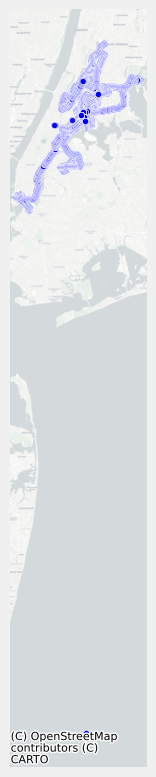

In [ ]:
#project the points to a basemap to visualize them
geo_table.plot(marker='o', color='darkblue', alpha=0.6)

### Join the csv file with the geojson (saptial_join)

Joined GeoTable Columns: ('geometry', 'SensorID', 'time', 'latitude', 'longitude', 'bin0', 'bin1', 'bin2', 'bin3', 'bin4', 'bin5', 'bin6', 'bin7', 'bin8', 'bin9', 'bin10', 'bin11', 'bin12', 'bin13', 'bin14', 'bin15', 'bin16', 'bin17', 'bin18', 'bin19', 'bin20', 'bin21', 'bin22', 'bin23', 'temperature', 'humidity', 'pm1', 'pm25', 'pm10', 'geohash', 'neighborhood', 'boroughCode', 'borough', '@id')


geometry,SensorID,time,latitude,longitude,bin0,bin1,bin2,bin3,bin4,bin5,bin6,bin7,bin8,bin9,bin10,bin11,bin12,bin13,bin14,bin15,bin16,bin17,bin18,bin19,bin20,bin21,bin22,bin23,temperature,humidity,pm1,pm25,pm10,geohash,neighborhood,boroughCode,borough,@id
POINT (-73.870087 40.847183),NYCP1_01A,1579618560,40.8472,-73.8701,23,1,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16.3,15.2,1.44,5.91,11.35,dr72rh1,Bronx Park,2,Bronx,http://nyc.pediacities.com/Resource/Neighborhood/Bronx_Park
POINT (-73.870094 40.847183),NYCP1_01A,1579618560,40.8472,-73.8701,18,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16.2,15.1,1.05,1.18,1.18,dr72rh1,Bronx Park,2,Bronx,http://nyc.pediacities.com/Resource/Neighborhood/Bronx_Park
POINT (-73.870094 40.847179),NYCP1_01A,1579618560,40.8472,-73.8701,18,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16.1,15.1,0.74,0.76,0.76,dr72rh1,Bronx Park,2,Bronx,http://nyc.pediacities.com/Resource/Neighborhood/Bronx_Park
POINT (-73.870094 40.847179),NYCP1_01A,1579618560,40.8472,-73.8701,18,1,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16.1,15.2,1.15,4.48,47.36,dr72rh1,Bronx Park,2,Bronx,http://nyc.pediacities.com/Resource/Neighborhood/Bronx_Park
POINT (-73.870094 40.847179),NYCP1_01A,1579618560,40.8472,-73.8701,20,3,0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16,15.2,2.13,5.77,6.18,dr72rh1,Bronx Park,2,Bronx,http://nyc.pediacities.com/Resource/Neighborhood/Bronx_Park


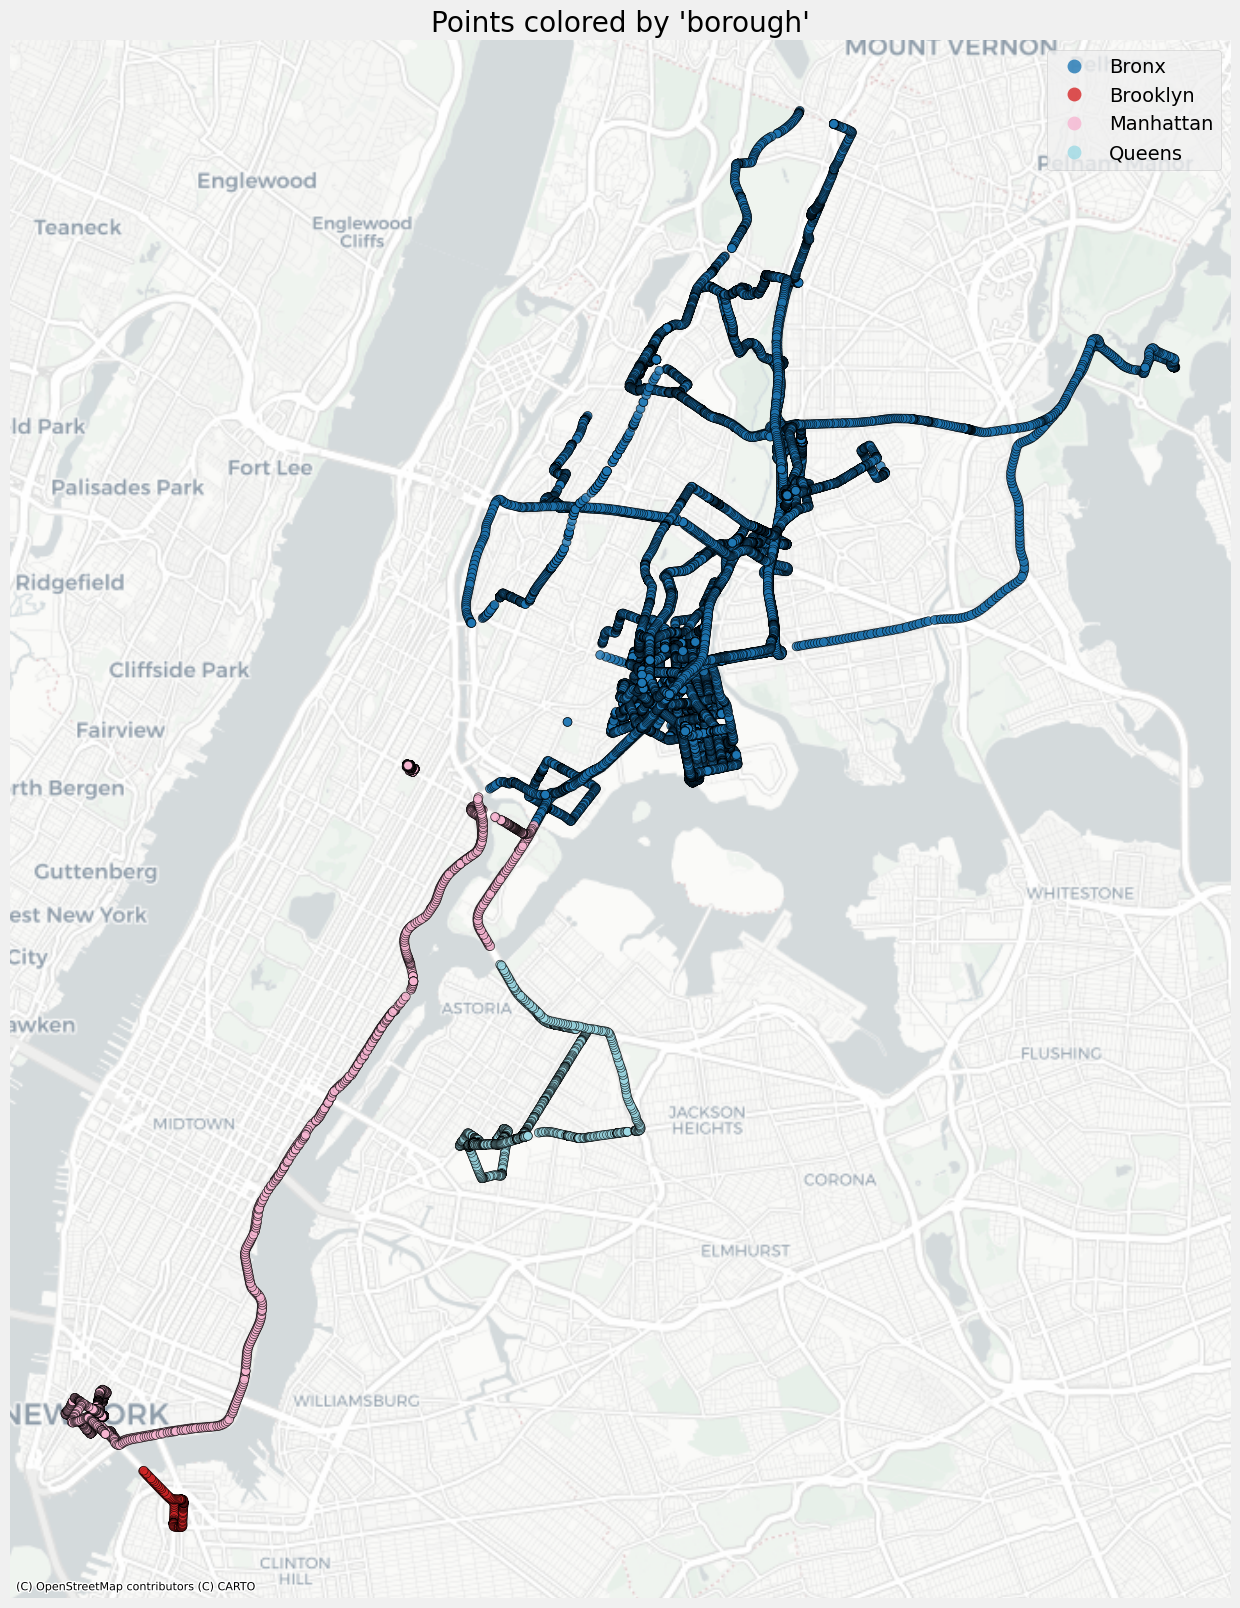

In [5]:
# Perform spatial join (points within polygons)
joined_gt = geo_table.spatial_join(nyc_neighborhoods, how='inner', predicate='within')

# Verify the joined data
print("Joined GeoTable Columns:", joined_gt.labels)
joined_gt.show(5)

import contextily as ctx
# Visualize the joined data
joined_gt.plot_sjoined_interactive(neighbor_col='borough')

#**select()**

**Purpose:** Selects columns while preserving geospatial properties when appropriate.

---

**Key Details:**

- Returns GeoTable if geometry column is selected

- Returns regular Table if only non-geometry columns selected

- Matches GeoPandas behavior

---

**Interpretation:**

- Maintains spatial operations if geometry kept

- Drops spatial capabilities if geometry excluded

- Example: select('geometry', 'city') keeps GeoTable, select('city') returns Table

In [ ]:
print("\n" + "="*80)
print("select() DEMONSTRATION - Geo-spatial column handling")
print("="*80)

# Case 1: Selecting geometry + attributes (stays GeoTable)
geo_subset = joined_gt.select('geometry', 'pm25', 'pm10', 'temperature', 'humidity', 'neighborhood')

print("\nCase 1: Geometry + attributes (GeoTable preserved):")
print(f"Type: {type(geo_subset)}")
print(f"Can do spatial ops: {hasattr(geo_subset, 'plot')}")
geo_subset.show(2)

# Case 2: Selecting only geometry (stays GeoTable)
geometry_only = joined_gt.select('geometry')
print("\nCase 2: Geometry only (GeoTable preserved):")
print(f"Type: {type(geometry_only)}")
print(f"Columns: {geometry_only.labels}")
geometry_only.show(2)

# Case 3: Selecting non-geometry columns (converts to Table)
data_only = joined_gt.select('pm25', 'temperature', 'neighborhood', 'humidity', 'borough', 'geohash')

print("\nCase 3: Non-geometry columns (converts to Table):")
print(f"Type: {type(data_only)}")
print(f"Has geometry: {'geometry' in data_only.labels}")
data_only.show(2)


select() DEMONSTRATION - Geo-spatial column handling

Case 1: Geometry + attributes (GeoTable preserved):
Type: <class '__main__.GeoTable'>
Can do spatial ops: True


geometry,pm25,pm10,temperature,humidity,neighborhood
POINT (-73.870087 40.847183),5.91,11.35,16.3,15.2,Bronx Park
POINT (-73.870094 40.847183),1.18,1.18,16.2,15.1,Bronx Park



Case 2: Geometry only (GeoTable preserved):
Type: <class '__main__.GeoTable'>
Columns: ('geometry',)


geometry
POINT (-73.870087 40.847183)
POINT (-73.870094 40.847183)



Case 3: Non-geometry columns (converts to Table):
Type: <class 'datascience.tables.Table'>
Has geometry: False


pm25,temperature,neighborhood,humidity,borough,geohash
5.91,16.3,Bronx Park,15.2,Bronx,dr72rh1
1.18,16.2,Bronx Park,15.1,Bronx,dr72rh1


print minimum and maximum pm10 values

In [ ]:
pm10 = geo_table.column('pm10')
print("Minimum PM10:", min(pm10))
print("Maximum PM10:", max(pm10))


Minimum PM10: 0.0
Maximum PM10: 87341.71


# **where()**

Purpose: Enhanced filtering that now handles both regular conditions and geospatial predicates.

---
**Key Details:**

- Extends base Table.where() functionality

- Supports new geometric predicates through are class

- Maintains all original filtering capabilities

- Seamlessly integrates with spatial operations



## **are.intersects()**
**Purpose:** Filters geometries that intersect with another shape.

---
Key Details:

- Uses Shapely's intersects() method

- Works with any geometry type (Point, Line, Polygon)

- Returns predicate function for use in where()


## **are.within()**
**Purpose:** Filters geometries completely contained within another shape.

---
**Key Details:**

- Uses Shapely's within() method

- Strict containment (not touching boundaries)

- Ideal for precise area selections


## **are.not_within()**
**Purpose:** Filters geometries that are not completely contained within another shape (inverse of within()).

---
**Key Details:**

Uses Shapely's within() method with logical negation (not operator)

---
**Returns geometries that:**

- Are completely outside the boundary OR

- Touch the boundary but aren't fully enclosed

- Perfect for exclusion zones and outlier detection

- Maintains identical precision to within() for spatial calculations

Found 1130 monitors completely INSIDE East Morrisania


SensorID,pm25,time
NYCP1_01A,1.18,1579619280
NYCP1_01A,1.68,1579619280
NYCP1_01A,1.08,1579619280


Found 1130 monitors TOUCHING East Morrisania (boundary included)
  - 0 are ON THE BOUNDARY


<ipython-input-8-6a0996aa34f1>:48: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


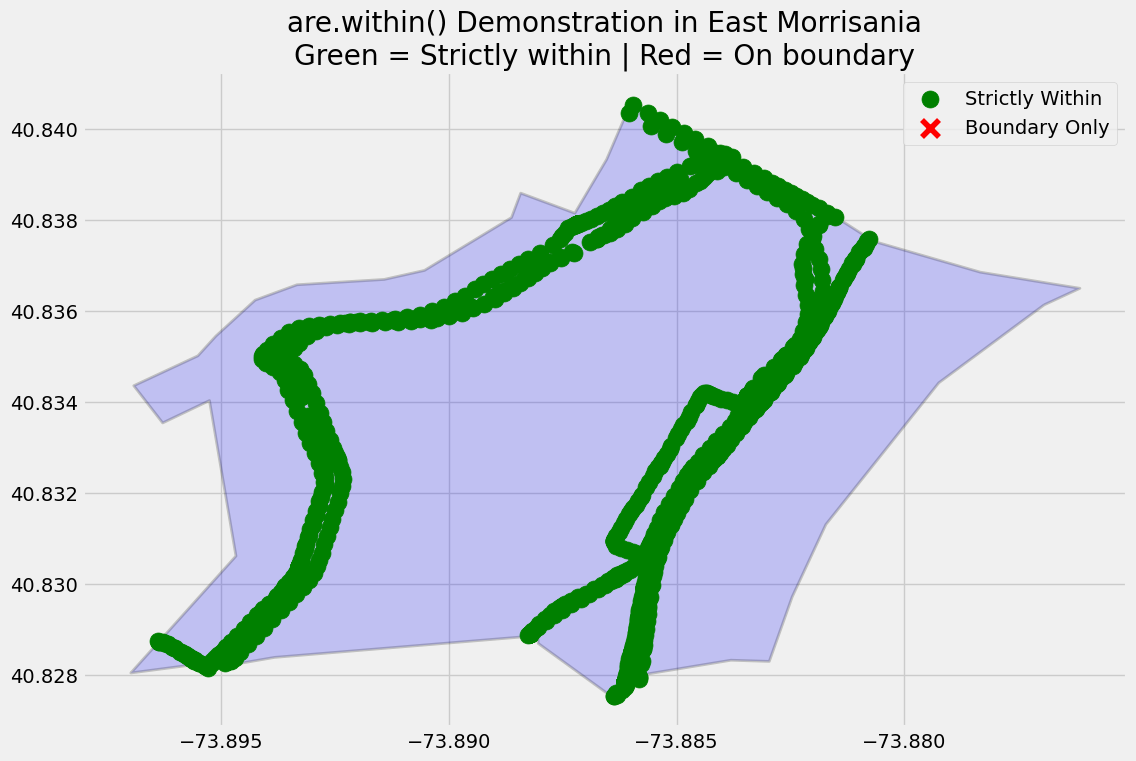

In [ ]:
# 1. Select a city/neighborhood
target_neighborhood = "East Morrisania"
fin_dist_geom = nyc_neighborhoods.where('neighborhood', are.equal_to(target_neighborhood)).column('geometry')[0]

strictly_within = joined_gt.where('geometry', are.within(fin_dist_geom))

print(f"Found {strictly_within.num_rows} monitors completely INSIDE {target_neighborhood}")
strictly_within.select('SensorID', 'pm25', 'time').show(3)

intersecting = joined_gt.where('geometry', are.intersects(fin_dist_geom))
print(f"Found {intersecting.num_rows} monitors TOUCHING {target_neighborhood} (boundary included)")



# Calculate difference (monitors on boundary)
boundary_monitors = intersecting.where('geometry', are.not_within(fin_dist_geom))
print(f"  - {boundary_monitors.num_rows} are ON THE BOUNDARY")


# 4. DEMONSTRATION 3: Visual Proof
fig, ax = plt.subplots(figsize=(12,10))


# Plot neighborhood boundary
gpd.GeoSeries([fin_dist_geom]).plot(ax=ax, color='blue', alpha=0.2,
                                  edgecolor='black', linewidth=2,
                                  label=target_neighborhood)

# Plot monitors
plt.scatter(
    [p.x for p in strictly_within.column('geometry')],
    [p.y for p in strictly_within.column('geometry')],
    c='green',
    s=150,
    marker='o',
    label='Strictly Within'
)

plt.scatter(
    [p.x for p in boundary_monitors.column('geometry')],
    [p.y for p in boundary_monitors.column('geometry')],
    c='red',
    s=150,
    marker='x',
    label='Boundary Only'
)

plt.legend()
plt.title(f"are.within() Demonstration in {target_neighborhood}\n"
          "Green = Strictly within | Red = On boundary")
plt.show()

In [ ]:
geo_table = geo_table.where('pm10', are.below(300))

## <font color = blue size  = 5>**Sampling and Empirical Distribution**

Sampling and empirical distribution are key concepts in statistics and data analysis, particularly when working with large datasets where it’s not feasible to analyze the entire population.
Sampling is the process of selecting a subset (sample) from a larger population to make inferences about that population. Since it is often impractical or impossible to collect data from every individual in a population, sampling allows us to estimate properties of the population based on the sample.

An empirical distribution is a statistical distribution based on observed data. It represents the frequency of each possible outcome in a sample. Unlike theoretical distributions (which are defined mathematically), empirical distributions are derived from real-world data.

- Randomly sample 10% of the rows from the joined_gt without replacement.
- Compute the mean pm10 value for this sample.
- Create an empirical histogram of the pm10 values from the sampled data using 30 bins.

In [ ]:
len(geo_table)

35

In [ ]:
geo_table.num_rows

117626

Mean PM10 value (sample): 15.9059182112


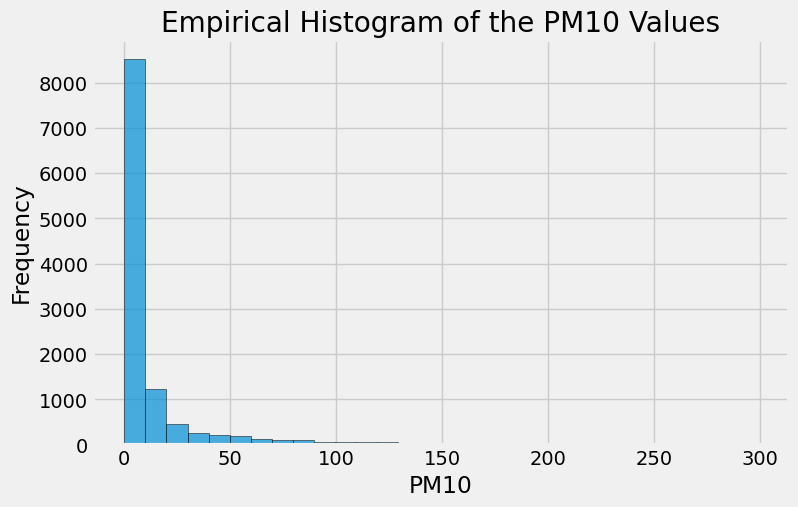

In [ ]:
# Randomly sample 10% of the rows without replacement
random_geo_table = geo_table.sample(int(geo_table.num_rows * 0.1), with_replacement=False)

# Compute the mean pm10 value for the sample
sample_pm10_mean = random_geo_table.column('pm10').mean()
print("Mean PM10 value (sample):", sample_pm10_mean)

# Create an empirical histogram of the pm10 values from the sample
plt.figure(figsize=(8, 5))
plt.hist(random_geo_table.column('pm10'), bins=30, edgecolor='black', alpha=0.7)
plt.title("Empirical Histogram of the PM10 Values")
plt.xlabel("PM10")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


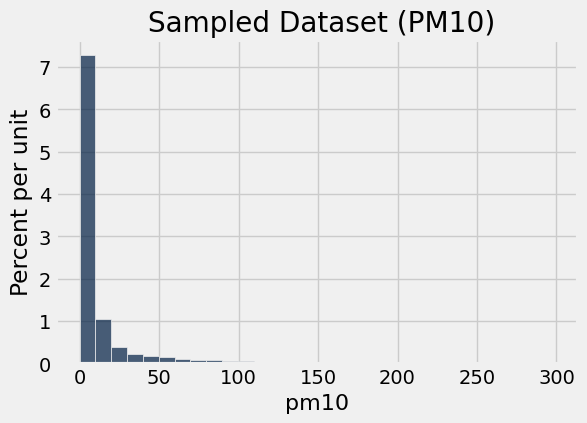

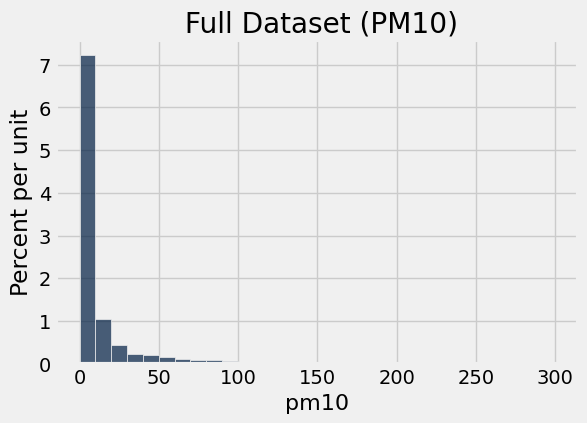

In [ ]:
#Create an overlay empirical histogram of the pm10 values from the sample vs full datasets
random_geo_table.hist('pm10', bins=30)
plt.title(' Sampled Dataset (PM10)')

geo_table.hist('pm10', bins=30)
plt.title(' Full Dataset (PM10)')

plt.show()

## <font color = blue size  = 5> **Estimation and Confidence Intervals**


Eatimation : method to infer unknown population parameters using random samples. Since complete population data is often unavailable, sample statistics like medians are used as estimates. The next part explores how to assess the variability of such estimates and begins by explaining percentiles, which are key to quantifying estimation error.

- Use the bootstrap method to estimate the median pm10 value for the entire dataset.
- Generate 5,000 bootstrap samples and compute the median for each sample.
- Construct a 95% confidence interval for the population median using the 2.5th and 97.5th percentiles of the bootstrapped medians.
- Visualize the results by drawing an `empirical histogram` of the bootstrapped medians and overlaying the confidence interval on the horizontal axis.

In [ ]:
#Perform bootstrap sampling to calculate the median of 'pm10' over 5000 samples
boot_median = geo_table.bootstrap_samples('pm10', 'median', num_repetitions=5000)

#Print the first few bootstrapped median values
print(boot_median[:10])

#Print the estimated median
etimated_median = np.median(boot_median)
print('Estimated Median pm10 value:' , etimated_median)

#Call percentile to get the confidence interval
lower_bound, upper_bound = geo_table.percentile(boot_median, confidence_level=95)

#Output the results
print(f"95% Confidence Interval: [{lower_bound}, {upper_bound}]")

[ 2.    2.87  1.34  3.39  2.05  3.12  3.25  2.05  3.24  2.5 ]
Estimated Median pm10 value: 3.13
95% Confidence Interval: [1.44, 7.06]


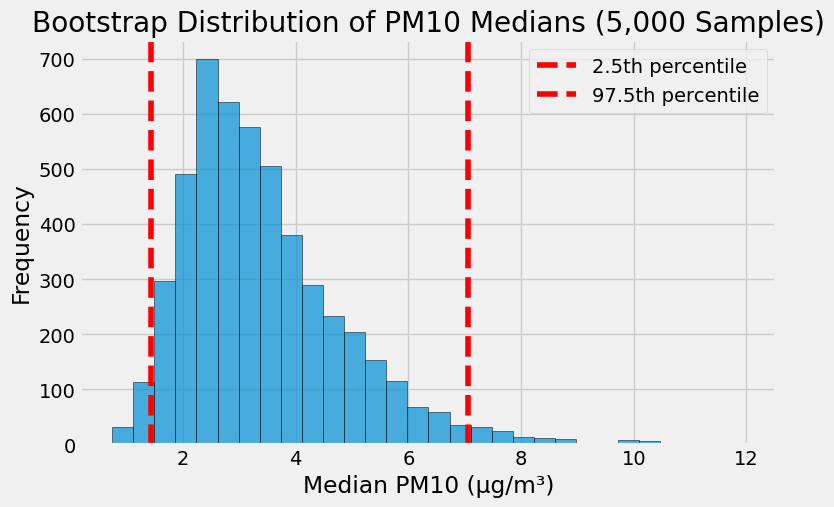

In [ ]:
#Draw histogram of bootstrapped medians
plt.figure(figsize=(8, 5))
plt.hist(boot_median, bins=30, edgecolor='black', alpha=0.7)
plt.axvline(lower_bound, color='red', linestyle='--', label='2.5th percentile')
plt.axvline(upper_bound, color='red', linestyle='--', label='97.5th percentile')
plt.title('Bootstrap Distribution of PM10 Medians (5,000 Samples)')
plt.xlabel('Median PM10 (μg/m³)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

## <font color = blue size  = 5> **Hypothesis Testing Using Confidence Intervals**

Hypothesis testing using confidence intervals allows us to make decisions about population parameters based on sample data. It provides a range of plausible values for the parameter and evaluates if the hypothesized value falls within this range, helping to determine whether to accept or reject the null hypothesis.

- Test the hypothesis about the average <font color = red size =5> `pm10` </font> level in the population using confidence intervals.
  - Null Hypothesis (H0): The average pm10 level in the population is `20 μg/m³` .
  - Alternative Hypothesis (Ha): The average pm10 level in the population is not `20 μg/m³` .
- Use the confidence interval method to test this hypothesis:
Construct a 95% confidence interval for the average `pm10` level in the population.
  - If the confidence interval contains `20 μg/m³` , conclude that there is no significant difference from `20 μg/m³` (fail to reject H0).
  - Otherwise, conclude that there is a significant difference (reject H0).
- Interpret your results and explain whether the data supports the null hypothesis or the alternative hypothesis.

Estimated mean pm10 value: 16.1191161714


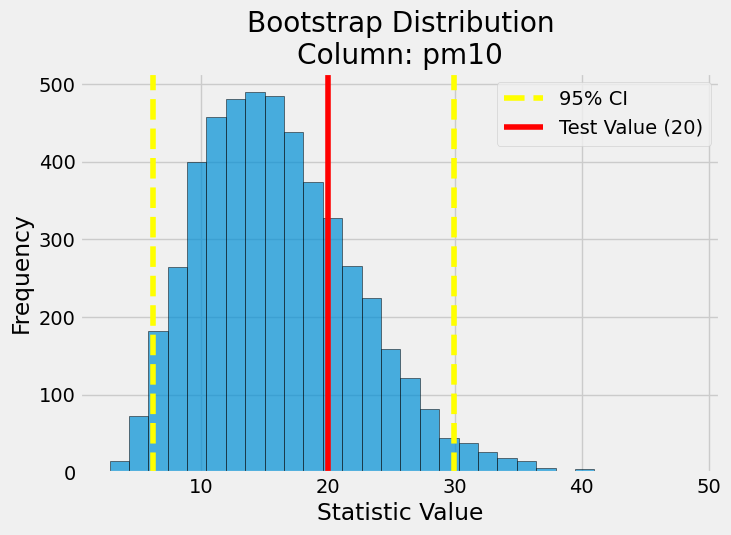

95% Confidence Interval for pm10: [6.20, 29.92]
Fail to reject the null hypothesis: 20 is within the 95% CI. No significant evidence that the statistic differs from 20.


In [ ]:
#Perform bootstrap sampling to calculate the mean of 'pm10' over 5000 samples
boot_mean = geo_table.bootstrap_samples('pm10', 'mean', num_repetitions=5000)

#Print the estimated median
etimated_mean = np.mean(boot_mean)
print('Estimated mean pm10 value:' , etimated_mean)

#Call percentile to get the confidence interval
lower_bound, upper_bound = geo_table.percentile(boot_mean, confidence_level=95)

#Perform Hypothesis Test
Hypothesis_Test = geo_table.hypothesis_test('pm10', boot_mean, 20, confidence_level=95, plot=True)


## <font color = blue size  = 5> **Estimation**

Eatimation : method to infer unknown population parameters using random samples. Since complete population data is often unavailable, sample statistics like medians are used as estimates. The next part explores how to assess the variability of such estimates and begins by explaining percentiles, which are key to quantifying estimation error.

This code tests the <font color = red size =5> `percentile` </font>  function by calculating a 95% confidence interval for the boot_median values, which are generated by repeatedly resampling the <font color = red size =5> `pm10` </font> column from the geo_table dataset and computing the median for each sample. The percentile function is used to extract the lower and upper bounds of the interval, providing a statistical estimate of the uncertainty around the true population median. This helps evaluate how much the sample-based estimate could vary due to randomness in sampling.


In [ ]:


# Extract PM10 data from your GeoTable
pm10_data = geo_table.column("pm10")

# Generate 5000 bootstrap medians
boot_median = [np.median(np.random.choice(pm10_data, size=len(pm10_data), replace=True)) for _ in range(5000)]

# Compute the 95% confidence interval using your custom percentile function
lower_bound, upper_bound = geo_table.percentile(boot_median, confidence_level=95)

# Output the results
print(f"95% Confidence Interval for Median PM10: [{lower_bound}, {upper_bound}]")


95% Confidence Interval for Median PM10: [3.09, 3.17]


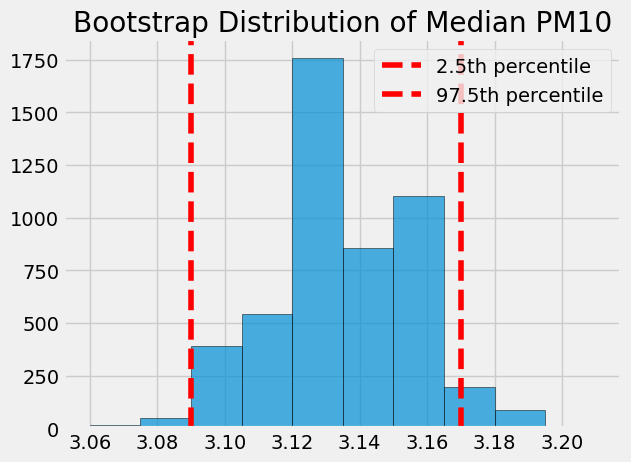

In [ ]:

plt.hist(boot_median, bins=10, edgecolor='black', alpha=0.7)
plt.axvline(lower_bound, color='red', linestyle='--', label='2.5th percentile')
plt.axvline(upper_bound, color='red', linestyle='--', label='97.5th percentile')
plt.title("Bootstrap Distribution of Median PM10")
plt.legend()
plt.grid(True)
plt.show()


## <font color = blue size  = 5> **Estimation - Bootstrap**

bootstrap method—a powerful resampling technique used to estimate the variability of a statistic, such as the median, when the true population parameter is unknown. By treating a single random sample as a stand-in for the population, the method repeatedly resamples from it (with replacement) to generate many "bootstrap samples." These samples are used to compute new estimates of the statistic, building an empirical distribution that reflects its variability. Through this, data scientists can construct confidence intervals and assess the reliability of their estimates without needing access to the full population—a practical approach when population data is too costly or unavailable.

In [ ]:
#test code
# Find top 3 neighborhoods with highest mean PM10
grouped = joined_gt.group('neighborhood', np.mean)
top3 = grouped.sort('pm10 mean', descending=True).column('neighborhood')[:3]

# Loop over each top neighborhood and run bootstrap
for neighborhood in top3:
    print(f"\n--- {neighborhood} ---")
    geo = joined_gt.where("neighborhood", neighborhood)

    # Bootstrap the mean pm10 values
    boot_stats = geo.bootstrap_samples(column_label="pm10", statistic_type="mean", num_repetitions=5000)

    # Compute 95% confidence interval
    lower, upper = geo.percentile(boot_stats, confidence_level=95)
    print(f"95% CI: [{lower:.2f}, {upper:.2f}]")




--- West Farms ---
95% CI: [8.63, 918.52]

--- Morris Park ---
95% CI: [36.69, 160.32]

--- Crotona Park ---
95% CI: [38.21, 71.14]


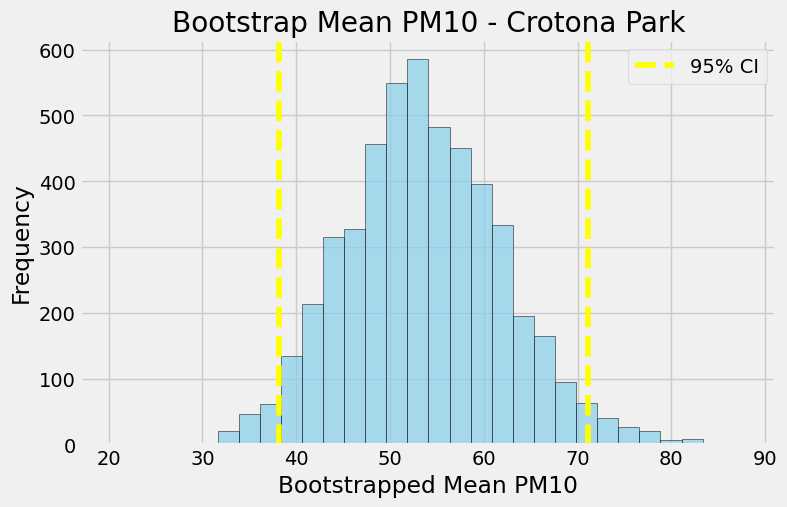

In [ ]:
# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(boot_stats, bins=30, edgecolor='black', color='skyblue', alpha=0.7)
plt.axvline(lower, color='yellow', linestyle='--', label='95% CI')
plt.axvline(upper, color='yellow', linestyle='--')
plt.title(f"Bootstrap Mean PM10 - {neighborhood}")
plt.xlabel("Bootstrapped Mean PM10")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()


Top 3 neighborhoods: ['West Farms' 'Morris Park' 'Crotona Park']


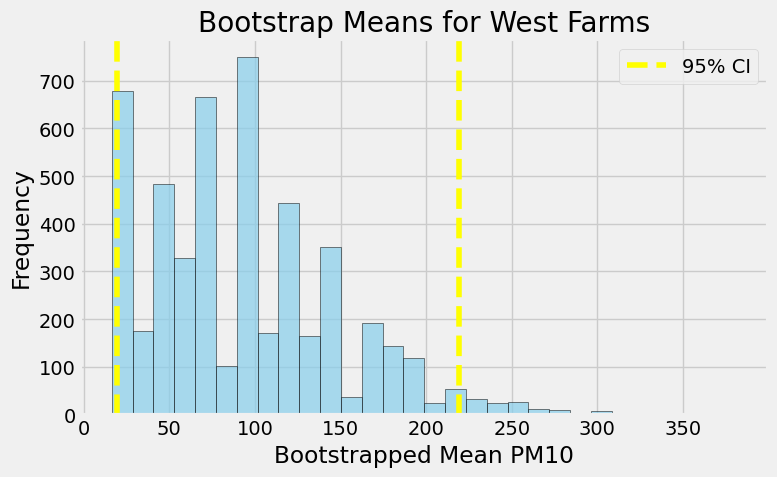

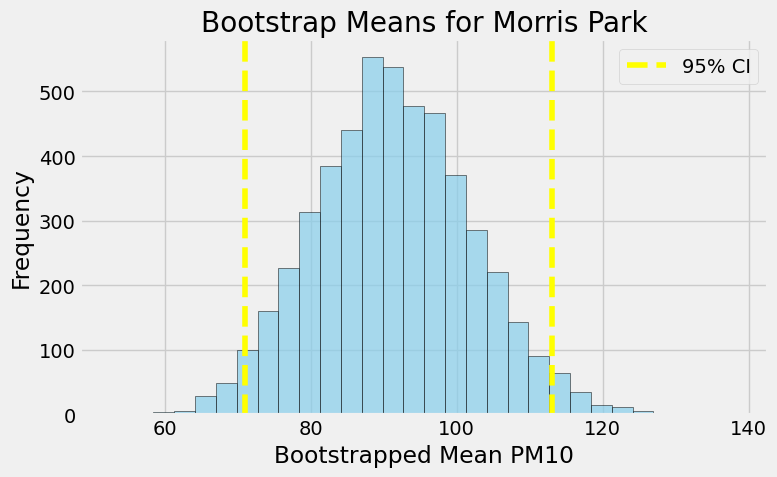

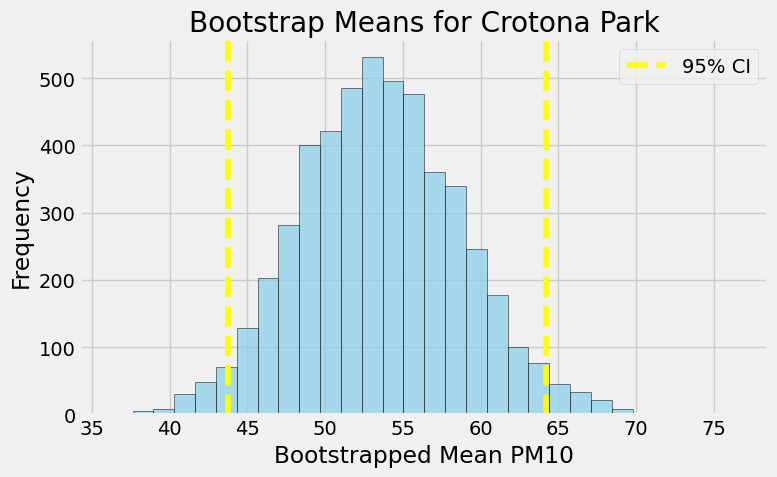

In [ ]:
# Step 1: Group by neighborhood and find mean pm10
grouped = joined_gt.group('neighborhood', np.mean)

# Step 2: Sort neighborhoods by highest mean pm10 and take top 3
top3 = grouped.sort('pm10 mean', descending=True).take(np.arange(3))
top3_neighborhoods = top3.column('neighborhood')
print('Top 3 neighborhoods:', top3_neighborhoods)

# Step 3: Define a bootstrap function for means
def bootstrap_means(table, column_name, repetitions=5000):
    means = []
    for _ in range(repetitions):
        resample = table.sample(k=table.num_rows, with_replacement=True)
        means.append(np.mean(resample.column(column_name)))
    return means

# Step 4: Bootstrap each top neighborhood and plot with matplotlib
for neighborhood in top3_neighborhoods:
    # Filter data for the specific neighborhood
    subset = joined_gt.where('neighborhood', are.equal_to(neighborhood))

    # Bootstrap the means
    bootstrapped_means = bootstrap_means(subset, 'pm10', repetitions=5000)

    # Calculate 95% confidence interval
    left = np.percentile(bootstrapped_means, 2.5)
    right = np.percentile(bootstrapped_means, 97.5)

    # Reusable table for inspection or debugging
    t = Table().with_column('Bootstrapped Means', bootstrapped_means)

    # Plot using matplotlib with enhanced aesthetics
    plt.figure(figsize=(8, 5))
    plt.hist(bootstrapped_means, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    plt.axvline(x=left, color='yellow', linestyle='--', label='95% CI')
    plt.axvline(x=right, color='yellow', linestyle='--')
    plt.title(f'Bootstrap Means for {neighborhood}')
    plt.xlabel("Bootstrapped Mean PM10")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


#Spatial-Numerical Correlation

In [7]:
#average points features based on neighborhoods so that each neighborhood has average feature of points with it
grouped = geo_table.spatial_groupby_mean(nyc_neighborhoods, features=["pm25", "humidity"])

In [8]:
#make sure to drop NAAN values
grouped = grouped.to_geodataframe().dropna(subset=["mean_pm25", "mean_humidity"])
grouped = GeoTable.from_df(grouped)

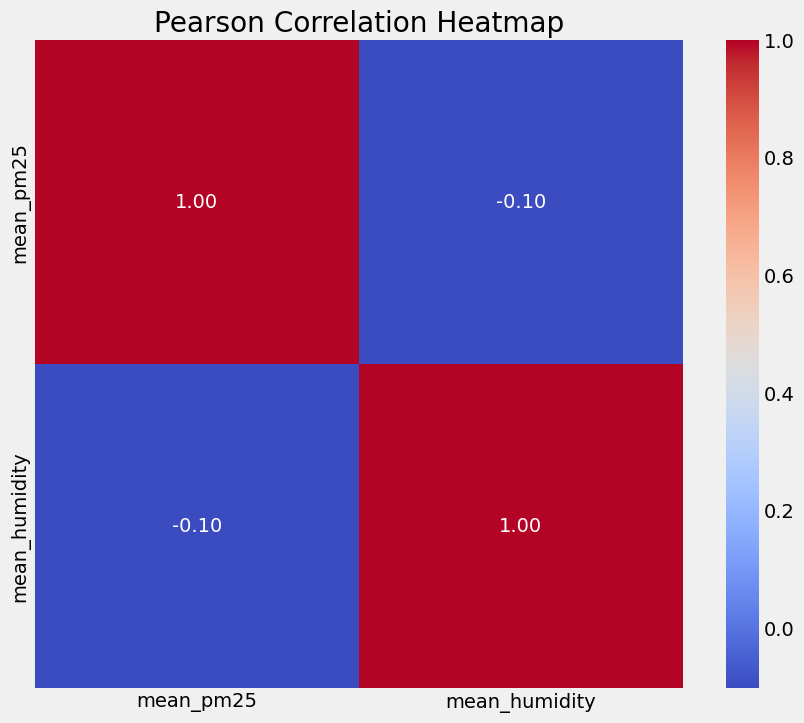

In [ ]:
# find the overall correlation between mean_pm25 and mean_humidity through analyzing each region's mean feature correlation
grouped.plot_correlation_heatmap()

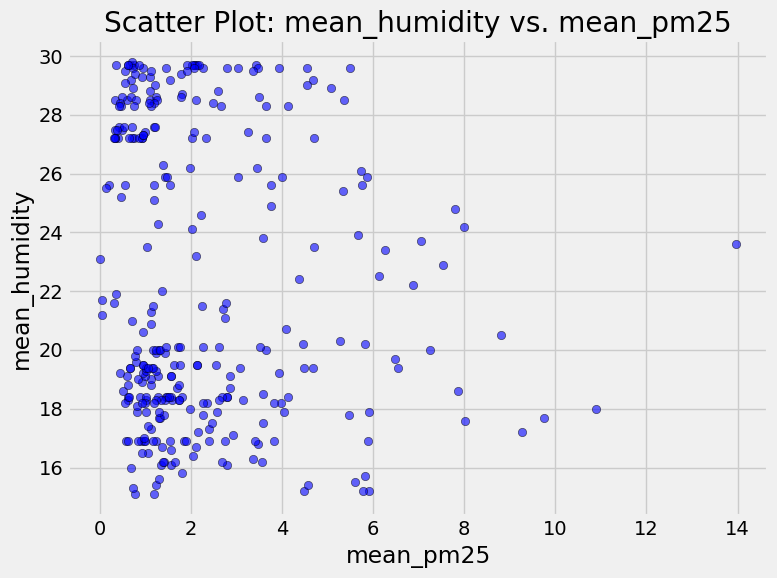

In [ ]:
#plot the correlation scatter plot
grouped.plot_spatial_scatter("mean_pm25", "mean_humidity")

Based on the correlation heatmap and the scatter plot there isn't a strong correlation between the density of pm25 and humidity a weak negative correlation of -0.1 was indicated which explains the vague pattern of the points in the scatter plot

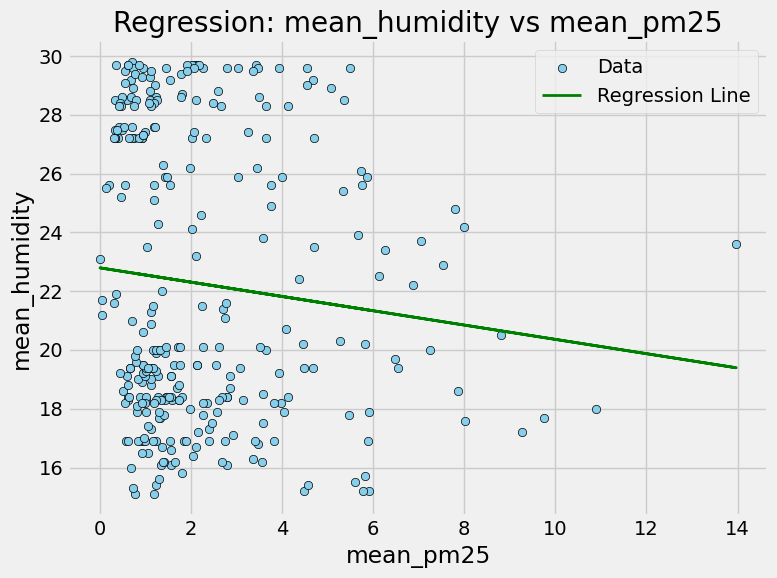

Regression Line: mean_humidity = -0.2434 * mean_pm25 + 22.7940


In [9]:
#fit the data into a regression model and plot the regression line
grouped.plot_spatial_regression("mean_pm25", "mean_humidity")

#You can also choose to plot more diagnostics


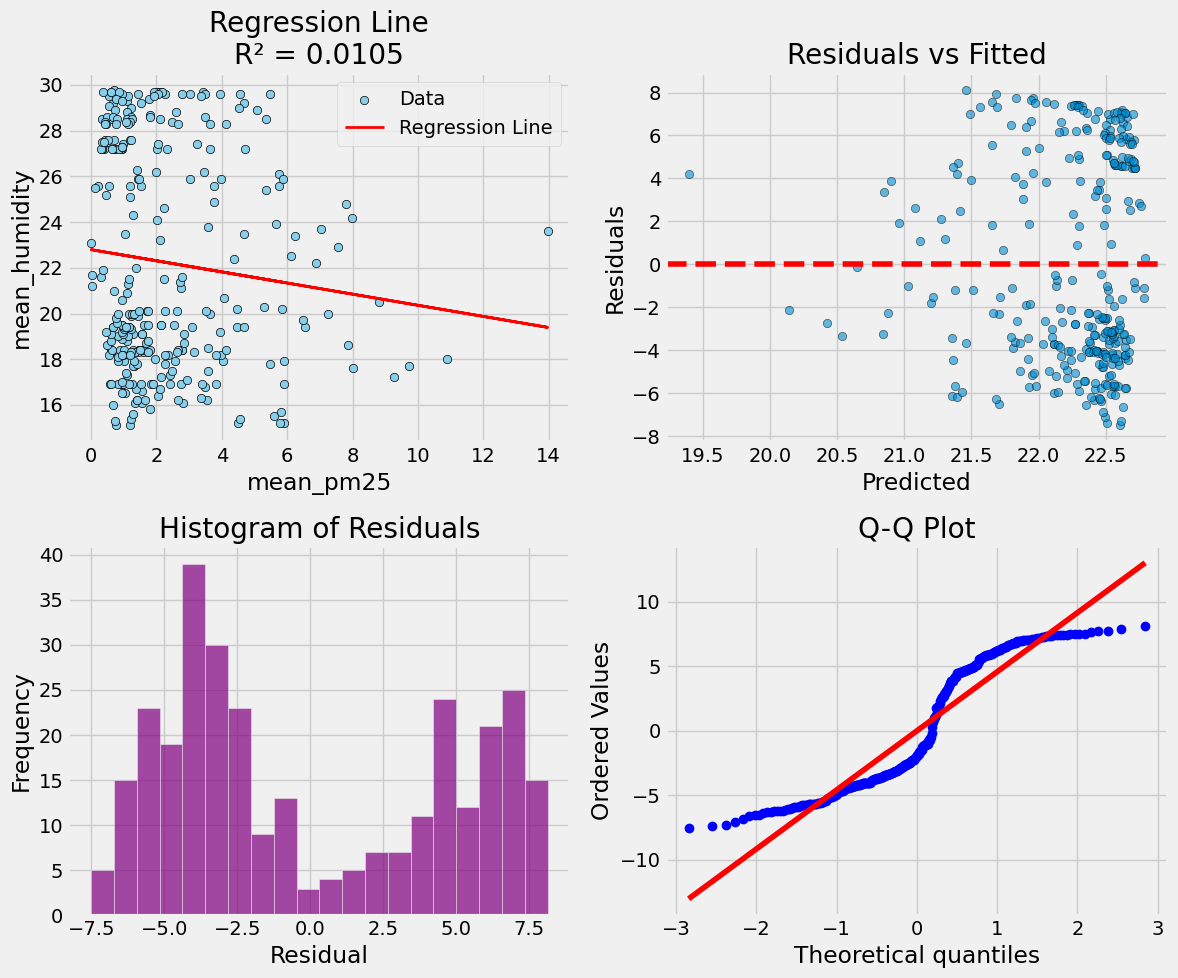

In [10]:
grouped.plot_regression_diagnostics("mean_pm25", "mean_humidity")

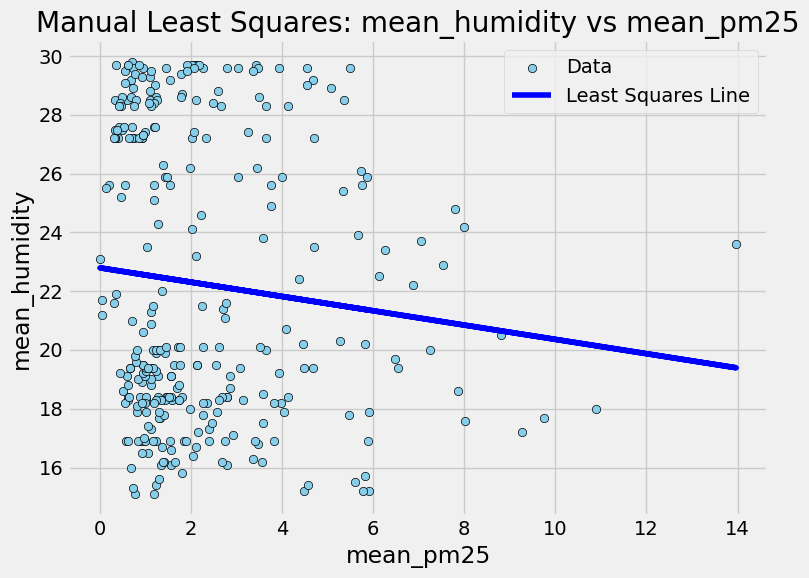

Manual Regression Line: mean_humidity = -0.2434 * mean_pm25 + 22.7940


In [11]:
#you can do manual regression using the least squares method
grouped.plot_manual_least_squares_regression("mean_pm25", "mean_humidity")

# Classification
**Classification** is a fundamental predictive technique in data science where the goal is to assign a categorical label to a new observation based on patterns learned from existing labeled data. In geospatial contexts, classification is often used to infer environmental conditions (like air quality), land usage, or risk levels at specific locations, using spatial and temporal features. By leveraging proximity, neighborhood data, and time, we can build models that learn from past observations to make educated guesses about unseen points.

In this section, we explored four custom geospatial classification methods implemented in the GeoTable framework:



# **Preprocessing:** Binning PM10 values into categorical classes
### Official PM10 Air Quality Categories ***(Based on WHO & EPA Standards)***

| PM10 Level (µg/m³) | Category                       | Health Implication                                                               |
| ------------------ | ------------------------------ | -------------------------------------------------------------------------------- |
| 0 – 54             | Good                           | Air quality is considered satisfactory.                                          |
| 55 – 154           | Moderate                       | Acceptable but may pose a risk for sensitive people.                             |
| 155 – 254          | Unhealthy for Sensitive Groups | May affect vulnerable groups like elderly, children, or those with lung disease. |
| 255 – 354          | Unhealthy                      | Everyone may begin to experience health effects.                                 |
| 355 – 424          | Very Unhealthy                 | Health alert: increased risk of effects for everyone.                            |
| 425+               | Hazardous                      | Serious health effects, emergency conditions.                                    |


---


In [ ]:
selected_table = joined_gt.select('geometry', 'SensorID', 'time', 'latitude', 'longitude', 'pm1', 'pm10', 'pm25', 'geohash', 'neighborhood', 'boroughCode', 'borough') # Usefull columns kept

def pm10_category(value):
    if value <= 54:
        return 'Good'
    elif value <= 154:
        return 'Moderate'
    elif value <= 254:
        return 'Unhealthy for Sensitive Groups'
    elif value <= 354:
        return 'Unhealthy'
    elif value <= 424:
        return 'Very Unhealthy'
    else:
        return 'Hazardous'

# Categorizing values based on PM10 value
class_table = selected_table.with_columns(
    'pm10_class', selected_table.apply(pm10_category, 'pm10')
)

class_table.select('neighborhood', 'pm10_class').show(5)

neighborhood,pm10_class
Bronx Park,Good
Bronx Park,Good
Bronx Park,Good
Bronx Park,Good
Bronx Park,Good


# **1. geo_knn_classify()**

The function uses a simple but effective spatial k-nearest neighbors approach with inverse-distance weighting to classify a new point based on its closest observations in space. We used it to classify air quality near Times Square.

---
### **Result Interpretation (in Air Quality context):**
The predicted PM10 class represents the most likely air quality category at the given location, based on nearby observations. Since this method uses the k geographically closest sensor readings, it assumes that locations close to each other tend to experience similar air quality conditions. The result reflects a localized estimation that adapts to the spatial distribution of real-world data.

In [ ]:
# This method predicts the PM10 class of a new, unknown location based on the labels of its geographically closest neighbors.

# Coordinates for a new location (e.g. near Central Park)
new_location = (40.7812, -73.9665)  # Test point (lat, lon)

# Run geo_knn_classify using the test point
predicted_neighborhood = class_table.geo_knn_classify(
    k=5,
    new_point=new_location,
    label_column='pm10_class',
    use_geometry=False  # we use lat/lon columns
)

print("Predicted PM10 class near Central Park:", predicted_neighborhood)

Predicted PM10 class near Central Park: Good


# **2. geo_temporal_knn()**

This function extends the basic KNN method by factoring in temporal closeness in addition to spatial distance. This helped us classify a location while prioritizing more recent data, making the prediction more responsive to short-term environmental shifts.

---
### **Result Interpretation (in Air Quality context):**
This function determines the air quality classification by considering not just where the query point is, but when. It looks for sensors nearby and readings taken around the same time. The result reflects the expected PM10 class for that place and time.
By adjusting the spatial vs temporal weight, you can simulate whether space or time is more influential — a powerful approach for studying evolving urban phenomena like air pollution.

In [ ]:
# Step 1: Choose a test location and a specific observation time
test_location = Point(-73.9855, 40.7580)  # Times Square
observation_time = datetime(2023, 9, 15, 12, 0, 0)  # Noon on a specific date

# Predict the PM class using geo-temporal distance
temporal_prediction = class_table.geo_temporal_knn(
    point=test_location,
    observation_time=observation_time,
    label_column='pm10_class',
    k=5,
    spatial_weight=0.6,
    temporal_weight=0.4,
)

print("Predicted PM10 Class (Geo-Temporal):", temporal_prediction)

Predicted PM10 Class (Geo-Temporal): Good


# **3. universal_geo_classifier()**
The function offers a more flexible and tunable classifier with support for different distance metrics (like Euclidean or Haversine) and weighting strategies (such as Gaussian decay). This allowed us to customize how neighbor influence decays and test classification sensitivity to distance models.

---
### **Result Interpretation (in Air Quality context):**
The predicted PM10 class for the specified point is based on a blend of nearby sensor readings, where each neighbor’s vote is influenced by how close it is. The use of Haversine distance ensures spatial accuracy, and Gaussian weighting provides a smoother influence decay with distance, which is useful when sensor density varies across the area. This makes the classifier especially robust in mixed-density urban environments like NYC.

In [ ]:
# Test location (Times Square, NYC)
test_location = Point(-73.9855, 40.7580)

# Run universal classifier
predicted_pm_class = class_table.universal_geo_classifier(
    point=test_location,
    label_column='pm10_class',
    k=5,
    distance_metric='haversine',
    weight_strategy='inverse_distance',
)

print("Predicted PM10 Class:", predicted_pm_class)

Predicted PM10 Class: Good


# **4. geo_ensemble_classify():**
This function combines multiple classifiers using majority voting to produce a more robust and stable classification. By aggregating different perspectives (spatial and temporal), this ensemble approach delivers a balanced and consensus-driven prediction.

---
### **Result Interpretation (in Air Quality context):**
The ensemble classifier aggregates insights from both spatial and temporal perspectives. It increases the confidence and reliability of the prediction by leveraging multiple decision strategies.
In real-world use, ensemble methods often outperform single models by reducing noise and overfitting — and here, it ensures a more holistic classification of air quality around Central Park.

In [ ]:
# test location Central Park, NYC
test_location = Point(-73.9712, 40.7831)

ensemble_prediction = class_table.geo_ensemble_classify(
    point=test_location,
    label_column='pm10_class',
    classifiers=[
        ('knn', {'k': 3, 'metric': 'haversine'}),
        ('temporal', {'hours': 12})
    ]
)

print("Predicted PM10 Class (Ensemble):", ensemble_prediction)

Predicted PM10 Class (Ensemble): Good
